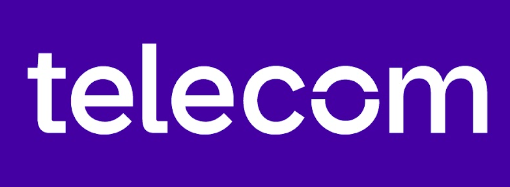

# Informe Final

En el presente trabajo consistio en los servicios de telecomunicaciones desarrollado por Telecom quienes estaban interesados en lograr determinar si un cliente actual estaba proximo a irse. 

Para desarrollar este proyecto se siguieron estos pasos:

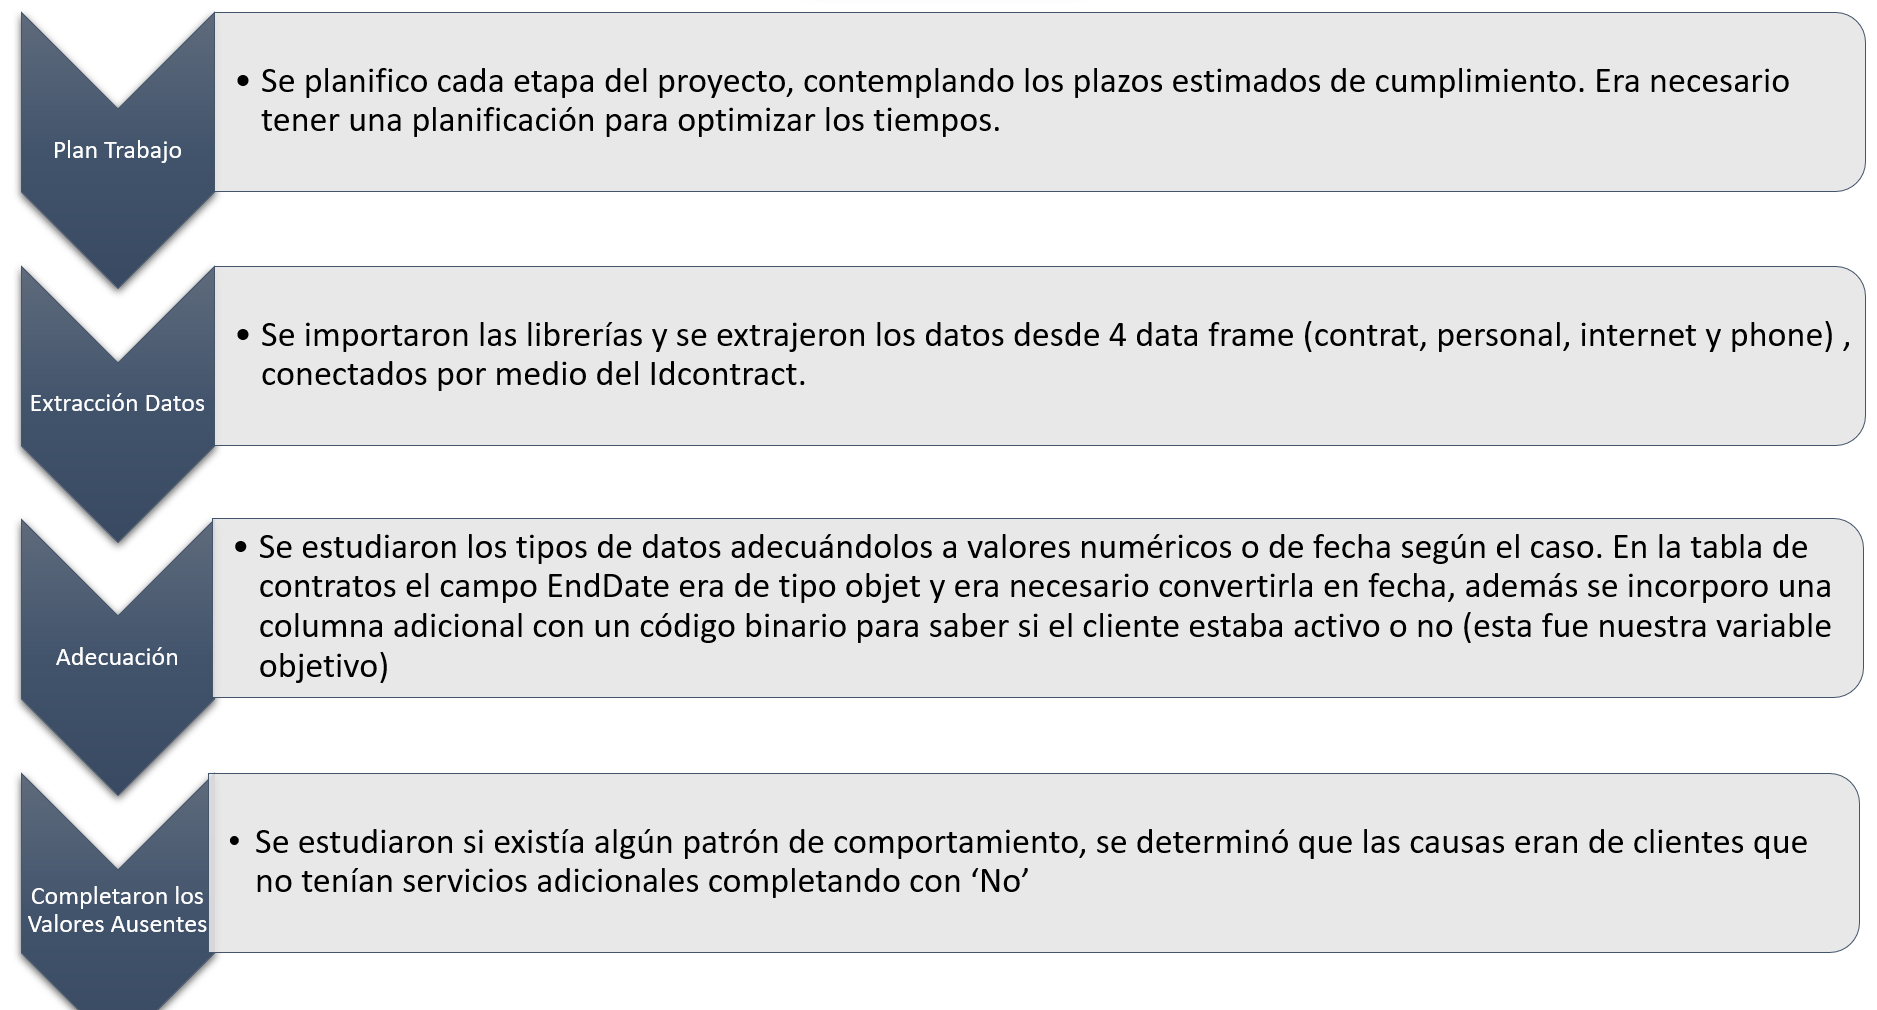

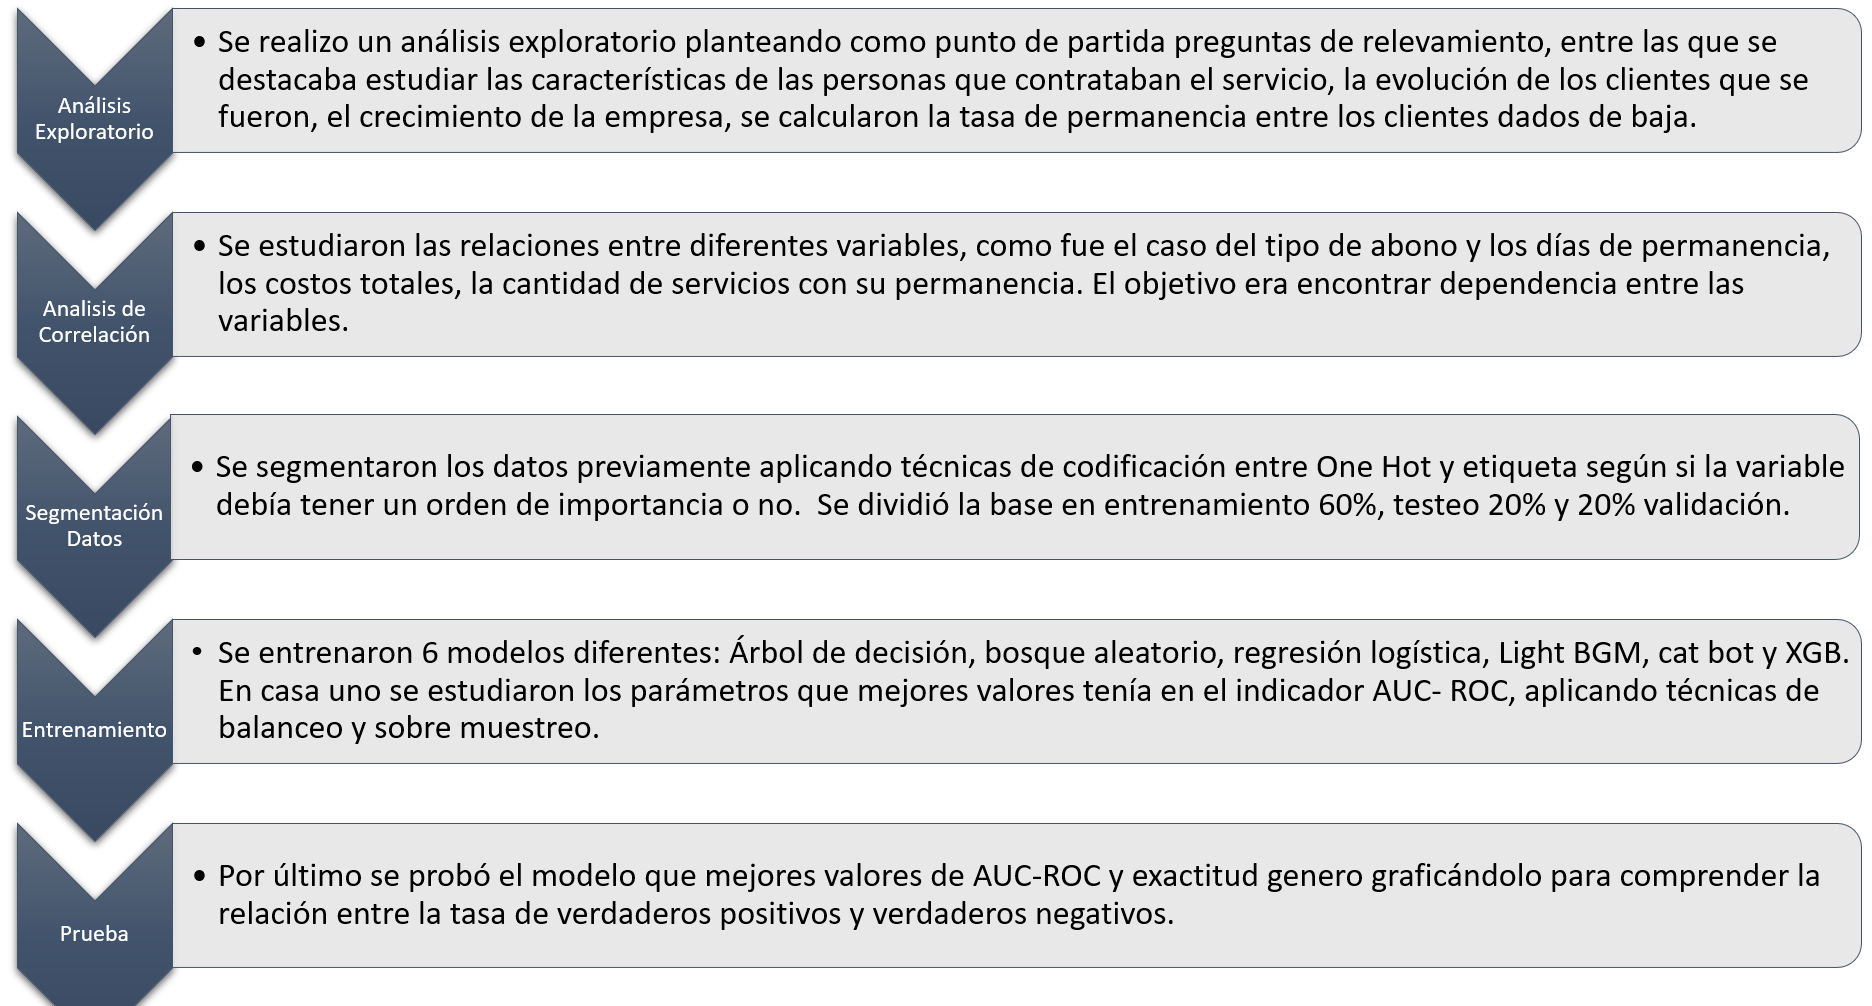

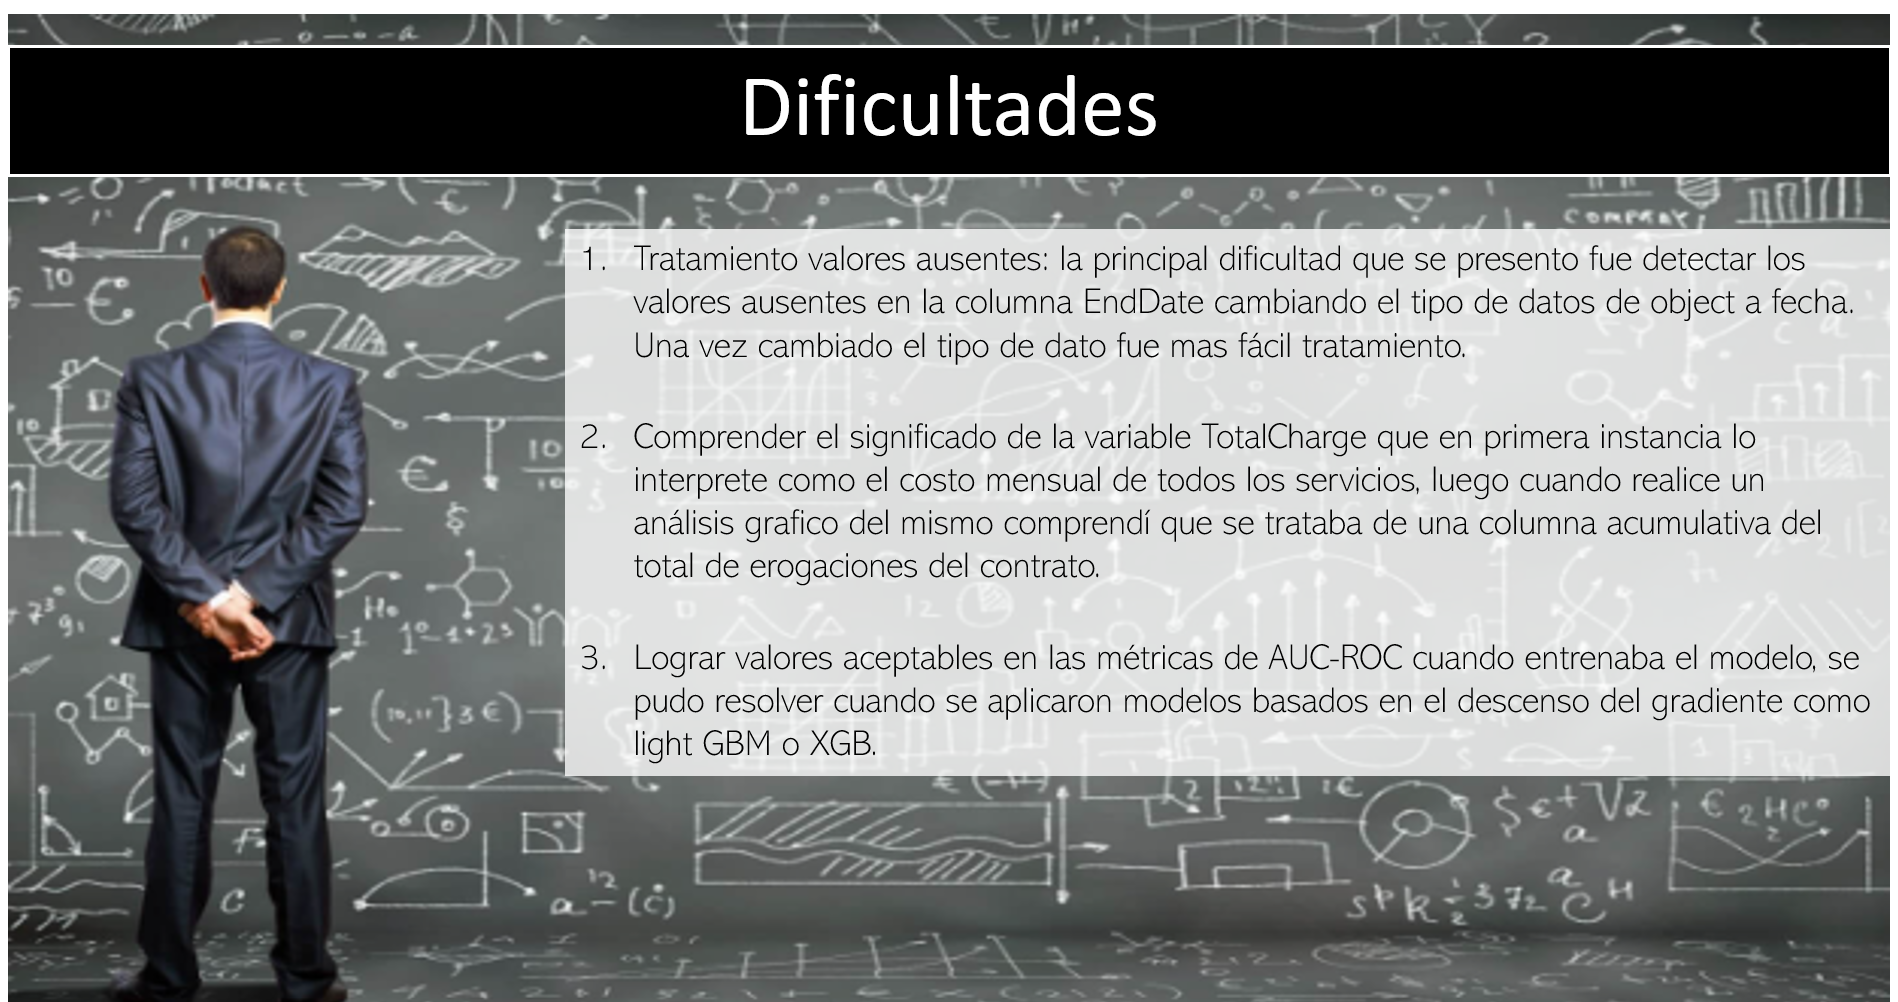

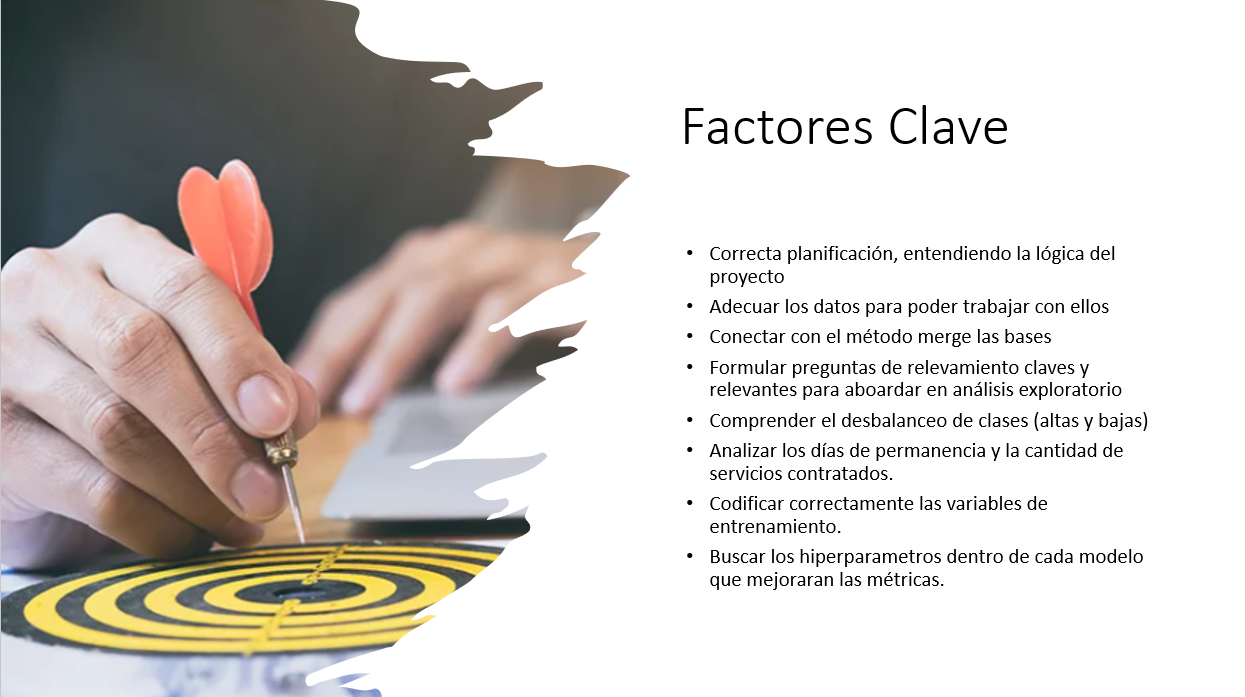

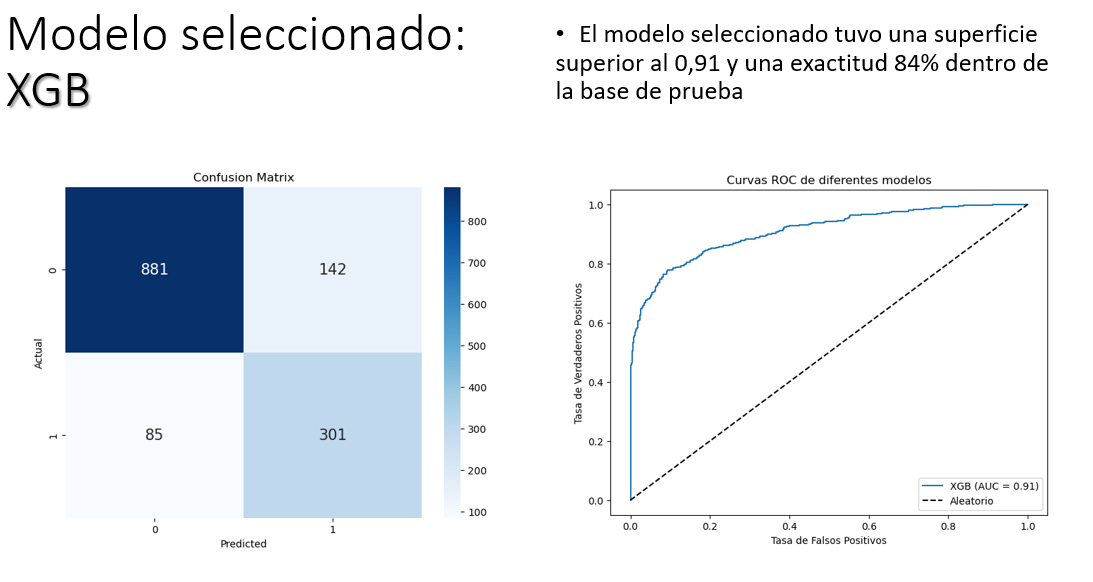

El modelo cumplio con los objetivos previstos dentro del proyecto para lograr predecir los clientes que pueden darse de baja.

A continuacion esta el detalle completo del trabajo:

### Descripcion del negocio

La empresa brinda servicios de telecomunicaciones, entre sus principales servicios se encuentra:

- Telefonia Fija
- Internet: 
    a- DSL
    b- Fibra Optica

Servicios adicionales:
- Seguridad Internet: proteccion de dispositivo y seguridad en linea
- Soporte Tenico
- Almacenamiento nube: backup Online
- Streaming Peliculas.



#### Objetivos

Telecom esta interesado en pronosticar la tasa de cancelacion de clientes.

Quiere saber si un usuario planea irse para ofrecerle promociones y opciones de planes especiales.

El equipo de Marketing ha recopilado algunas datos personales de los clientes.

- contract.csv — información del contrato
- personal.csv — datos personales del cliente
-  internet.csv — información sobre los servicios de Internet
- phone.csv — información sobre los servicios telefónicos

La metrica a utilizar es AUC - ROC

Metrica adicional: exactitud

#### Plan de trabajo

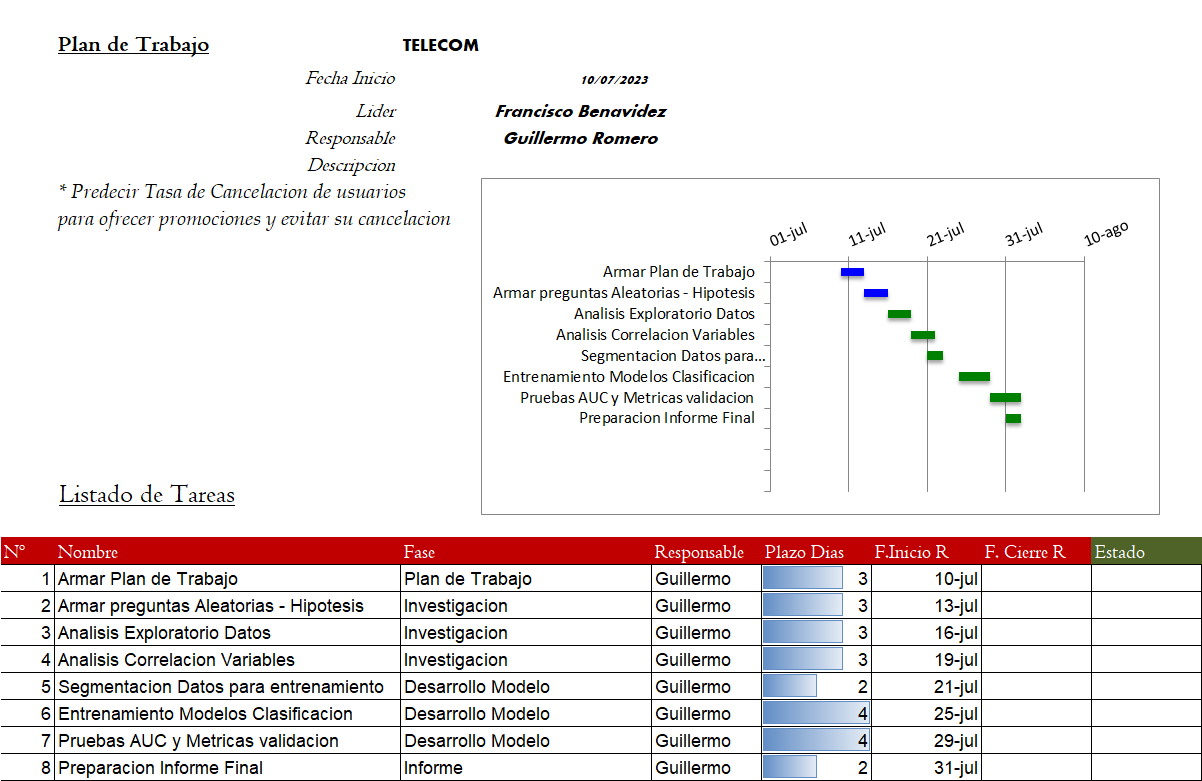

In [1]:
# Cargar todas las librerías

#Elementales
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats as st

#Modelos de ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from catboost import CatBoostClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


#Metricas y Herramientas de ML
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle



#### Extraccion Datos

In [2]:
# Directorio base

base_dir_loc = 'G:\\Mi unidad\\Posgrados\\Data Sciencia\\Proyectos\\Proyecto Final\\'
''
base_dir_web = '/datasets/final_provider/'

# Nombre del archivo
contract='contract.csv'
personal='personal.csv'
internet= 'internet.csv'
phone='phone.csv'

# Ruta completa
#ruta_completa = os.path.join(base_dir, archivo)c

# Imprimir la ruta completa
#print(ruta_completa)

In [3]:
# Carga el archivo de datos en un DataFrame
try:
    df_contract=pd.read_csv(base_dir_loc+contract)
    df_personal=pd.read_csv(base_dir_loc+personal)
    df_internet=pd.read_csv(base_dir_loc+internet)
    df_phone=pd.read_csv(base_dir_loc+phone)
    
except:
    df_contract = pd.read_csv(base_dir_web+contract)
    df_personal=pd.read_csv(base_dir_web+personal)
    df_internet=pd.read_csv(base_dir_web+internet)
    df_phone=pd.read_csv(base_dir_web+phone)


##### Contract

In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.describe()

MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000

In [6]:
df_contract.head()

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

La tabla contiene datos de los contratos donde cada uno esta identificado por customerID el resto de los campos serian:

* BeginDate : inicio del contrato
* EndDate: Finalizacion del contrato si fuera el caso
* Type: es la modalidad del contrato, si es anual, mensual.
* PaperlessBilling: Si esta con factura electronica o no
* PaymentMethod: es el metodo de pago elegido
* Mothly Charges: Cargo Mensual por el servicio princial
* TotalCharges: es el total costo de los servicios contratados

Tanto BeginData como EndDate estan como dato tipo objeto y deberia ser fecha, para ello vamos a aplicar algunas correcciones a los tipos de datos y agregar algunas columanas, como años y meses que podrian ser de utilidad para la parte de analisis.


In [7]:
#correguimos el tipo de dato
df_contract['BeginDate']=pd.to_datetime(df_contract['BeginDate'])
df_contract['year_begin']=pd.DatetimeIndex(df_contract['BeginDate']).year
df_contract['month_begin']=pd.DatetimeIndex(df_contract['BeginDate']).month

In [8]:
df_contract['EndDate'] = df_contract['EndDate'].replace({'No': None})
df_contract['EndDate']=pd.to_datetime(df_contract['EndDate'])
df_contract['year_end']=pd.DatetimeIndex(df_contract['EndDate']).year
df_contract['year_end'] = df_contract['year_end'].replace(1970, 0)
df_contract['month_end']=pd.DatetimeIndex(df_contract['EndDate']).month

In [9]:
df_contract

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01        NaT        One year               No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01        NaT        One year               No   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7038  6840-RESVB 2018-02-01        NaT        One year              Yes   
7039  2234-XADUH 2014-02-01        NaT        One year              Yes   
7040  4801-JZAZL 2019-03-01        NaT  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01        NaT        Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges  year_begin  \
0              Electronic check           29.85        29.85        2020   
1                  Mailed check           56.95       1889.5        2017   
2                  Mailed check           53.85       108.15        2019   
3     Bank transfer (automatic)           42.30      1840.75        2016   
4              Electronic check           70.70       151.65        2019   
...                         ...             ...          ...         ...   
7038               Mailed check           84.80       1990.5        2018   
7039    Credit card (automatic)          103.20       7362.9        2014   
7040           Electronic check           29.60       346.45        2019   
7041               Mailed check           74.40        306.6        2019   
7042  Bank transfer (automatic)          105.65       6844.5        2014   

      month_begin  year_end  month_end  
0               1       NaN        NaN  
1               4       NaN        NaN  
2              10    2019.0       12.0  
3               5       NaN        NaN  
4               9    2019.0       11.0  
...           ...       ...        ...  
7038            2       NaN        NaN  
7039            2       NaN        NaN  
7040            3       NaN        NaN  
7041            7    2019.0       11.0  
7042            8       NaN        NaN  

[7043 rows x 12 columns]

In [10]:
#Cambiar el tipo de dato a totalCharges
def clean_and_convert_to_numeric(value):
    value = str(value).strip() 
    try:
        return float(value) 
    except ValueError:
        return None  


df_contract['TotalCharges'] = df_contract['TotalCharges'].apply(clean_and_convert_to_numeric)



Aqui cambiamos el tipo de dato de TotalCharges por un tipo de dato numerico para poder aplicar operaciones matematicas y analisis respecto al total de cargos aplicados.

In [11]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  year_end          1869 non-null   float64       
 11  month_end         1869 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(4)
memory usage: 660.4+ KB


Querdaron 5.174 registros ausentes en el campo EndDate que corresponde a los contratos que estan actualmente activos.  



##### Personal

In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [13]:
df_personal.describe()

SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

In [14]:
df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Esta base contiene datos de las personas que han contratado el servicio

* customerID: clave principal
* gender: genero
* SeniorCitizen: Si es Jubilado
* Parther: si esta en pareja
* Dependents: si esta en relacion de dependencia

Los valores respetan la integralidad de los datos para su analisis, sera requerido cambiar el tipo de datos de las columnas gender, parther y dependents a valores binarios; dicho cambio se efectuara en la seccion de segmentacion de datos. 

####  internet

In [15]:
 df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
df_internet.describe()

customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

In [17]:
df_internet.head()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

Son los servicios secundarios contratados por los usuarios. 

* InternetService: es el tipo de  internet contratado DSL o Fibra optica
* OnlineSecurity: es el paquete de seguridad
* Onlibackup: el servicio en la nube
* DeviceProtection:Proteccion
* TechSupport: servicio tecnico
* StramingMovies: el servicio de streming

Hay 5517 registros para cada contrato, lo que indica que 1.526 contratos no tienen servicios secundarios.

Igual que en la seccion anterior se aplicara tecnicas de etiquedado para convertir los valores Yes y No en codigo binario para su entrenamiento, dicho cambio se efectura en la seccion de segmentacion. 

#### Phone

In [18]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
df_phone.describe()

customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

In [20]:
df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Es si es una unica linea o son multiples. Hay 3390 registros `No` 

igual que en los comentarios anteriores, lo correcto es convertirlo en un codigo binario para poder entrenarlo. 

#### Resumen y union bases

Las bases de datos estan conectadas por el campo customerID siendo la tabla principal contract y personal, y estas se relacionan con internet y phone.

Agrupando todas las bases a una por medio de una consulta quedaria asi:


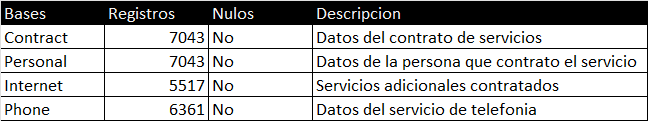

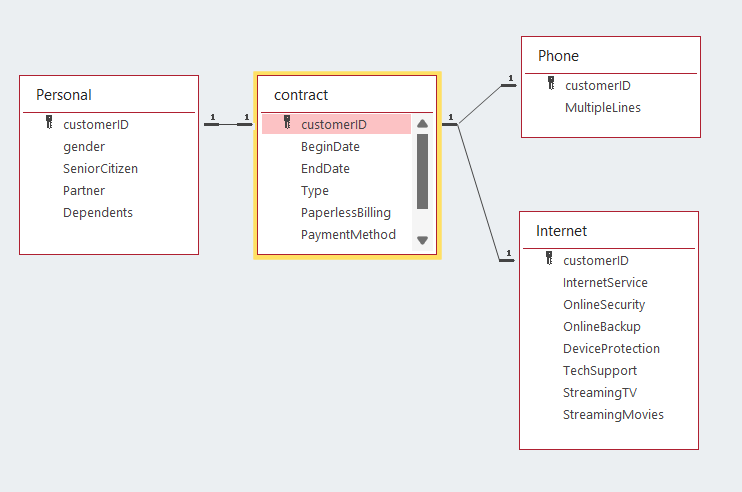

In [21]:
# Unir las bases de datos
df_merged = pd.merge(df_contract, df_personal, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_internet, on='customerID', how='left')
df_merged = pd.merge(df_merged, df_phone, on='customerID', how='left')

In [22]:
df_merged

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0     7590-VHVEG 2020-01-01        NaT  Month-to-month              Yes   
1     5575-GNVDE 2017-04-01        NaT        One year               No   
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month              Yes   
3     7795-CFOCW 2016-05-01        NaT        One year               No   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month              Yes   
...          ...        ...        ...             ...              ...   
7038  6840-RESVB 2018-02-01        NaT        One year              Yes   
7039  2234-XADUH 2014-02-01        NaT        One year              Yes   
7040  4801-JZAZL 2019-03-01        NaT  Month-to-month              Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month              Yes   
7042  3186-AJIEK 2014-08-01        NaT        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  year_begin  \
0              Electronic check           29.85         29.85        2020   
1                  Mailed check           56.95       1889.50        2017   
2                  Mailed check           53.85        108.15        2019   
3     Bank transfer (automatic)           42.30       1840.75        2016   
4              Electronic check           70.70        151.65        2019   
...                         ...             ...           ...         ...   
7038               Mailed check           84.80       1990.50        2018   
7039    Credit card (automatic)          103.20       7362.90        2014   
7040           Electronic check           29.60        346.45        2019   
7041               Mailed check           74.40        306.60        2019   
7042  Bank transfer (automatic)          105.65       6844.50        2014   

      month_begin  ...  Partner  Dependents InternetService  OnlineSecurity  \
0               1  ...      Yes          No             DSL              No   
1               4  ...       No          No             DSL             Yes   
2              10  ...       No          No             DSL             Yes   
3               5  ...       No          No             DSL             Yes   
4               9  ...       No          No     Fiber optic              No   
...           ...  ...      ...         ...             ...             ...   
7038            2  ...      Yes         Yes             DSL             Yes   
7039            2  ...      Yes         Yes     Fiber optic              No   
7040            3  ...      Yes         Yes             DSL             Yes   
7041            7  ...      Yes          No     Fiber optic              No   
7042            8  ...       No          No     Fiber optic             Yes   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0             Yes               No          No          No              No   
1              No              Yes          No          No              No   
2             Yes               No          No          No              No   
3              No              Yes         Yes          No              No   
4              No               No          No          No              No   
...           ...              ...         ...         ...             ...   
7038           No              Yes         Yes         Yes             Yes   
7039          Yes              Yes          No         Yes             Yes   
7040           No               No          No          No              No   
7041           No               No          No          No              No   
7042           No              Yes         Yes         Yes             Yes   

     MultipleLines  
0              NaN  
1               No  
2               No  
3              NaN  
4               No  
...            ...  
7038           Yes  
7039           Yes  
7040           NaN  
7041           Yes  
7042            No  

[7043 rows x 24 columns]

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  year_end          1869 non-null   float64       
 11  month_end         1869 non-null   float64       
 12  gender            7043 non-null   object        
 13  SeniorCitizen     7043 non-null   int64         
 14  Partner           7043 n

#### Valores Ausentes

Al unir las tablas, vemos que existen valores ausentes, observemos donde se producen y si tienen algun patron:

In [24]:
df_null=df_merged.loc[df_merged['OnlineSecurity'].isnull()]
df_null.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1526 entries, 11 to 7037
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1526 non-null   object        
 1   BeginDate         1526 non-null   datetime64[ns]
 2   EndDate           113 non-null    datetime64[ns]
 3   Type              1526 non-null   object        
 4   PaperlessBilling  1526 non-null   object        
 5   PaymentMethod     1526 non-null   object        
 6   MonthlyCharges    1526 non-null   float64       
 7   TotalCharges      1520 non-null   float64       
 8   year_begin        1526 non-null   int64         
 9   month_begin       1526 non-null   int64         
 10  year_end          113 non-null    float64       
 11  month_end         113 non-null    float64       
 12  gender            1526 non-null   object        
 13  SeniorCitizen     1526 non-null   int64         
 14  Partner           1526 

In [25]:
df_null

customerID  BeginDate    EndDate            Type PaperlessBilling  \
11    7469-LKBCI 2018-10-01        NaT        Two year               No   
16    8191-XWSZG 2015-10-01        NaT        One year               No   
21    1680-VDCWW 2019-02-01        NaT        One year               No   
22    1066-JKSGK 2019-11-01 2019-12-01  Month-to-month               No   
33    7310-EGVHZ 2020-01-01        NaT  Month-to-month               No   
...          ...        ...        ...             ...              ...   
7017  4807-IZYOZ 2015-11-01        NaT        Two year               No   
7019  9710-NJERN 2016-11-01        NaT        Two year               No   
7020  9837-FWLCH 2019-02-01        NaT  Month-to-month              Yes   
7030  0871-OPBXW 2019-12-01        NaT  Month-to-month              Yes   
7037  2569-WGERO 2014-02-01        NaT        Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  year_begin  \
11      Credit card (automatic)           18.95        326.80        2018   
16                 Mailed check           20.65       1022.95        2015   
21    Bank transfer (automatic)           19.80        202.25        2019   
22                 Mailed check           20.15         20.15        2019   
33    Bank transfer (automatic)           20.20         20.20        2020   
...                         ...             ...           ...         ...   
7017  Bank transfer (automatic)           20.65       1020.75        2015   
7019               Mailed check           20.15        826.00        2016   
7020           Electronic check           19.20        239.00        2019   
7030               Mailed check           20.05         39.25        2019   
7037  Bank transfer (automatic)           21.15       1419.40        2014   

      month_begin  ...  Partner  Dependents InternetService  OnlineSecurity  \
11             10  ...       No          No             NaN             NaN   
16             10  ...       No          No             NaN             NaN   
21              2  ...      Yes          No             NaN             NaN   
22             11  ...       No          No             NaN             NaN   
33              1  ...       No          No             NaN             NaN   
...           ...  ...      ...         ...             ...             ...   
7017           11  ...       No          No             NaN             NaN   
7019           11  ...       No          No             NaN             NaN   
7020            2  ...      Yes         Yes             NaN             NaN   
7030           12  ...       No          No             NaN             NaN   
7037            2  ...       No          No             NaN             NaN   

     OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
11            NaN              NaN         NaN         NaN             NaN   
16            NaN              NaN         NaN         NaN             NaN   
21            NaN              NaN         NaN         NaN             NaN   
22            NaN              NaN         NaN         NaN             NaN   
33            NaN              NaN         NaN         NaN             NaN   
...           ...              ...         ...         ...             ...   
7017          NaN              NaN         NaN         NaN             NaN   
7019          NaN              NaN         NaN         NaN             NaN   
7020          NaN              NaN         NaN         NaN             NaN   
7030          NaN              NaN         NaN         NaN             NaN   
7037          NaN              NaN         NaN         NaN             NaN   

     MultipleLines  
11              No  
16              No  
21              No  
22              No  
33              No  
...            ...  
7017            No  
7019            No  
7020            No  
7030            No  
7037            No  

[1526 rows x 24 columns]

Existen 1.526 valores ausentes provenientes de los datos de las tablas Internet y 512 provenientes de los datos de phone, lo que hace un total de 2.038

Los valores ausentes provienen de usuarios que no tienen servicios adicionales o bien lineas, por lo que completamos los valores ausentes como 'No' y luego como apliquemos la tecnicas de codificacion se aplique correctamente.

Tambien vamos a agregar una columna adicional con un codigo binario siendo 0 si el cliente esta activo y 1 si el mismo finalizo su contrato.


In [26]:
df_merged['InternetService'].fillna('No', inplace=True)
df_merged['OnlineSecurity'].fillna('No', inplace=True)
df_merged['OnlineBackup'].fillna('No', inplace=True)
df_merged['DeviceProtection'].fillna('No', inplace=True)
df_merged['TechSupport'].fillna('No', inplace=True)
df_merged['StreamingTV'].fillna('No', inplace=True)
df_merged['StreamingMovies'].fillna('No', inplace=True)
df_merged['MultipleLines'].fillna('No', inplace=True)
df_merged['year_end'].fillna(0, inplace=True)
df_merged['month_end'].fillna(0, inplace=True)
df_merged['TotalCharges'].fillna(0, inplace=True)
df_merged['HasEndDate'] = np.where(pd.isnull(df_merged['EndDate']), 0, 1)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   year_begin        7043 non-null   int64         
 9   month_begin       7043 non-null   int64         
 10  year_end          7043 non-null   float64       
 11  month_end         7043 non-null   float64       
 12  gender            7043 non-null   object        
 13  SeniorCitizen     7043 non-null   int64         
 14  Partner           7043 n

#### Buenas practicas y conversion del tipo de datos

Cambiaremos los nombres de las columnas para llevar todo a minuscula.

Tambien vamos a cambiar el tipo de dato de begindate y endate por tipo fecha de la tabla df_contract.

In [27]:
# renombra las columnas
df_merged = df_merged.rename(columns=lambda x: x.lower())


In [28]:
columnas_actuales = df_merged.columns.tolist()

In [29]:
columnas_actuales

['customerid',
 'begindate',
 'enddate',
 'type',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'year_begin',
 'month_begin',
 'year_end',
 'month_end',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'multiplelines',
 'hasenddate']

In [30]:
# lista
nuevos_nombres = ['customer_id', 'begin_date', 'end_date','type','paperless_billing', 'payment_method', 'monthly_charges',
                 'total_charges', 'year_begin','month_begin', 'year_end','month_end','gender', 'senior_citizen','partner','dependents','internet_service','online_security',
                 'online_backup','device_protection','tech_support','streming_tv','streaming_movies','multiple_lines','has_end_date']

In [31]:
df_merged.columns = nuevos_nombres

In [32]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   year_begin         7043 non-null   int64         
 9   month_begin        7043 non-null   int64         
 10  year_end           7043 non-null   float64       
 11  month_end          7043 non-null   float64       
 12  gender             7043 non-null   object        
 13  senior_citizen     7043 non-null   int64         
 14  partner 

#### Preguntas de relevamiento

* Existen contratos que no tienen contratado servicios adicionales?
* Habra una correlacion entre las caracteristicas del usuario y los contratos adicionales
* Que aspectos haran que los usuarios tengan pensado cancelar los contratos.
* Puede ser una hipotesis que tenga que ver con el tipo de plan de pago, si es mensual o anual? o mas bien con el servicio de telefonia?
* Se podrian armar grupos de usuarios con caracteristicas similares para proponer promociones relacionadas a los grupos. 

Respecto a la primer cuestion que nos planteamos hemos visto que existen **1.526 contratos que no tienen servicios adicionales.**

Sobre las **caracteritiscas de los usuarios** y los contratos adicionales, en primera instancia no podemos visualizarlo por lo que deberemos hacer un analisis grafico para entender como se han comportado y que caractertisticas tenian los usuarios que contrataron servicios adicionales, tambien vamos a ver si de esos usuarios algunos se dieron de baja para encontrar de ser posible algun patron de comportamiento.

Analizaremos si el tipo de plan ha influido en los usuarios para decidir abandonar o quedarse.

Se plantea para responder estas preguntas y cumplir con los objetivos del cliente el plan de trabajo anteriormente propuesto y manteniendo el siguiente indice:

* [2 -Analisis Exploratorio](#2)
* [3 -Analisis Correlacion y Grafico](#3)
* [4 -Segmentacion Datos](#4)
* [5 -Modelizacion](#5)
* [6 -Prueba AUC](#6)
* [7 -Conclusiones](#7)

## Analisis Exploratorio <a id='2'></a>

### Analisis Caracteristicas Personales

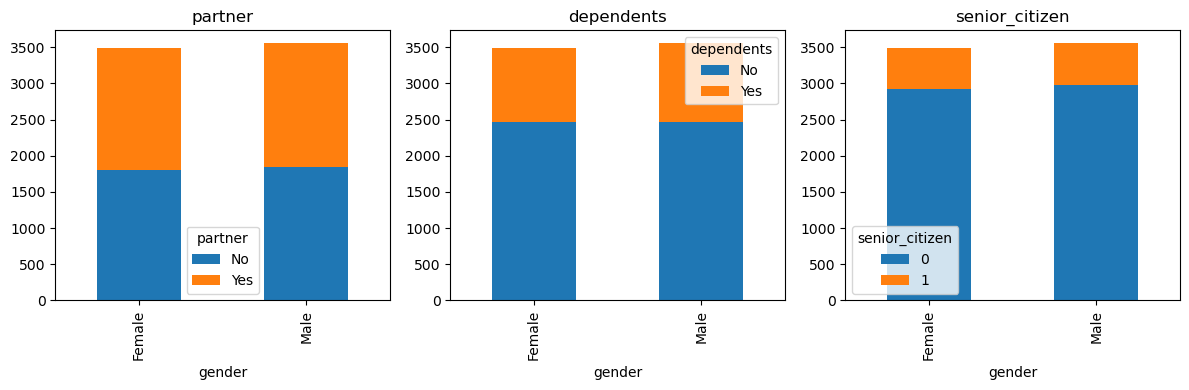

In [33]:
#analisis Genero
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

variables = ['partner', 'dependents', 'senior_citizen']

for i, variable in enumerate(variables):
    gender = df_merged.pivot_table(index='gender', columns=variable, values='begin_date', aggfunc='count')
    gender.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(variable)

plt.tight_layout()
plt.show()

Analizando por genero las diferentes caracteristicas de las personas, se puede decir que esta balanceado, ya que no existe una predominancia de algun grupo segregado entre hombres y mujeres

Por otra parte podemos ver que existe igual cantidad de personas en pareja, que la mayoria en un 75% no esta en dependencia y que tan solo un 20% es jubilada.

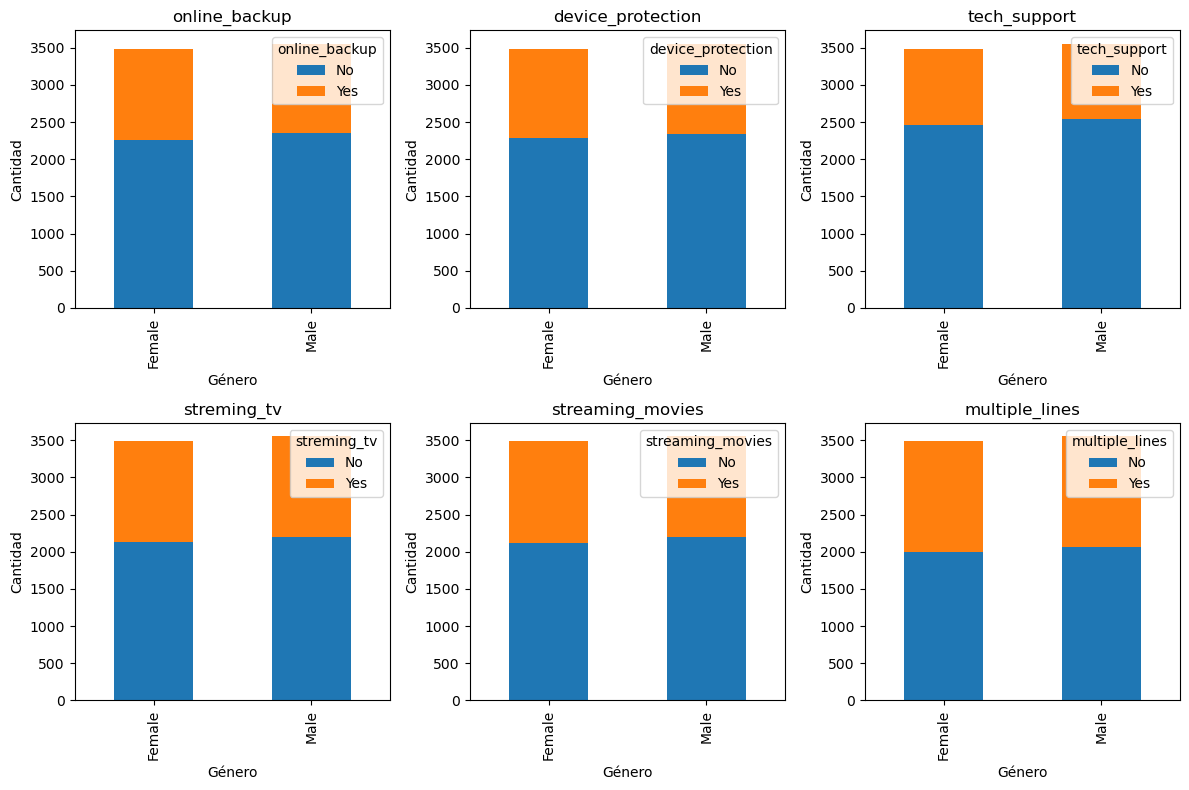

In [34]:
additional_services = ['online_backup', 'device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, service in enumerate(additional_services):
    ax = axes[i // 3, i % 3]
    gender_service = df_merged.groupby(['gender', service])[service].count().unstack()
    gender_service.plot(kind='bar', stacked=True, ax=ax)
    ax.set_xlabel('Género')
    ax.set_ylabel('Cantidad')
    ax.set_title(service)
    ax.legend(title=service)

plt.tight_layout()
plt.show()

In [35]:
additional_services = ['online_backup', 'device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']

service_counts = df_merged[additional_services].apply(pd.Series.value_counts)

service_counts

online_backup  device_protection  tech_support  streming_tv  \
No            4614               4621          4999         4336   
Yes           2429               2422          2044         2707   

     streaming_movies  multiple_lines  
No               4311            4072  
Yes              2732            2971

Por genero tampoco se aprecia ningun comportamiento selectivo entre los servicios que contratan los hombres y los que contratan las mujeres. 

#### End Date

Veamos que comportamiento tienen determinadas caracteristicas en los usuarios que se han ido y como ha sido la evolucion 

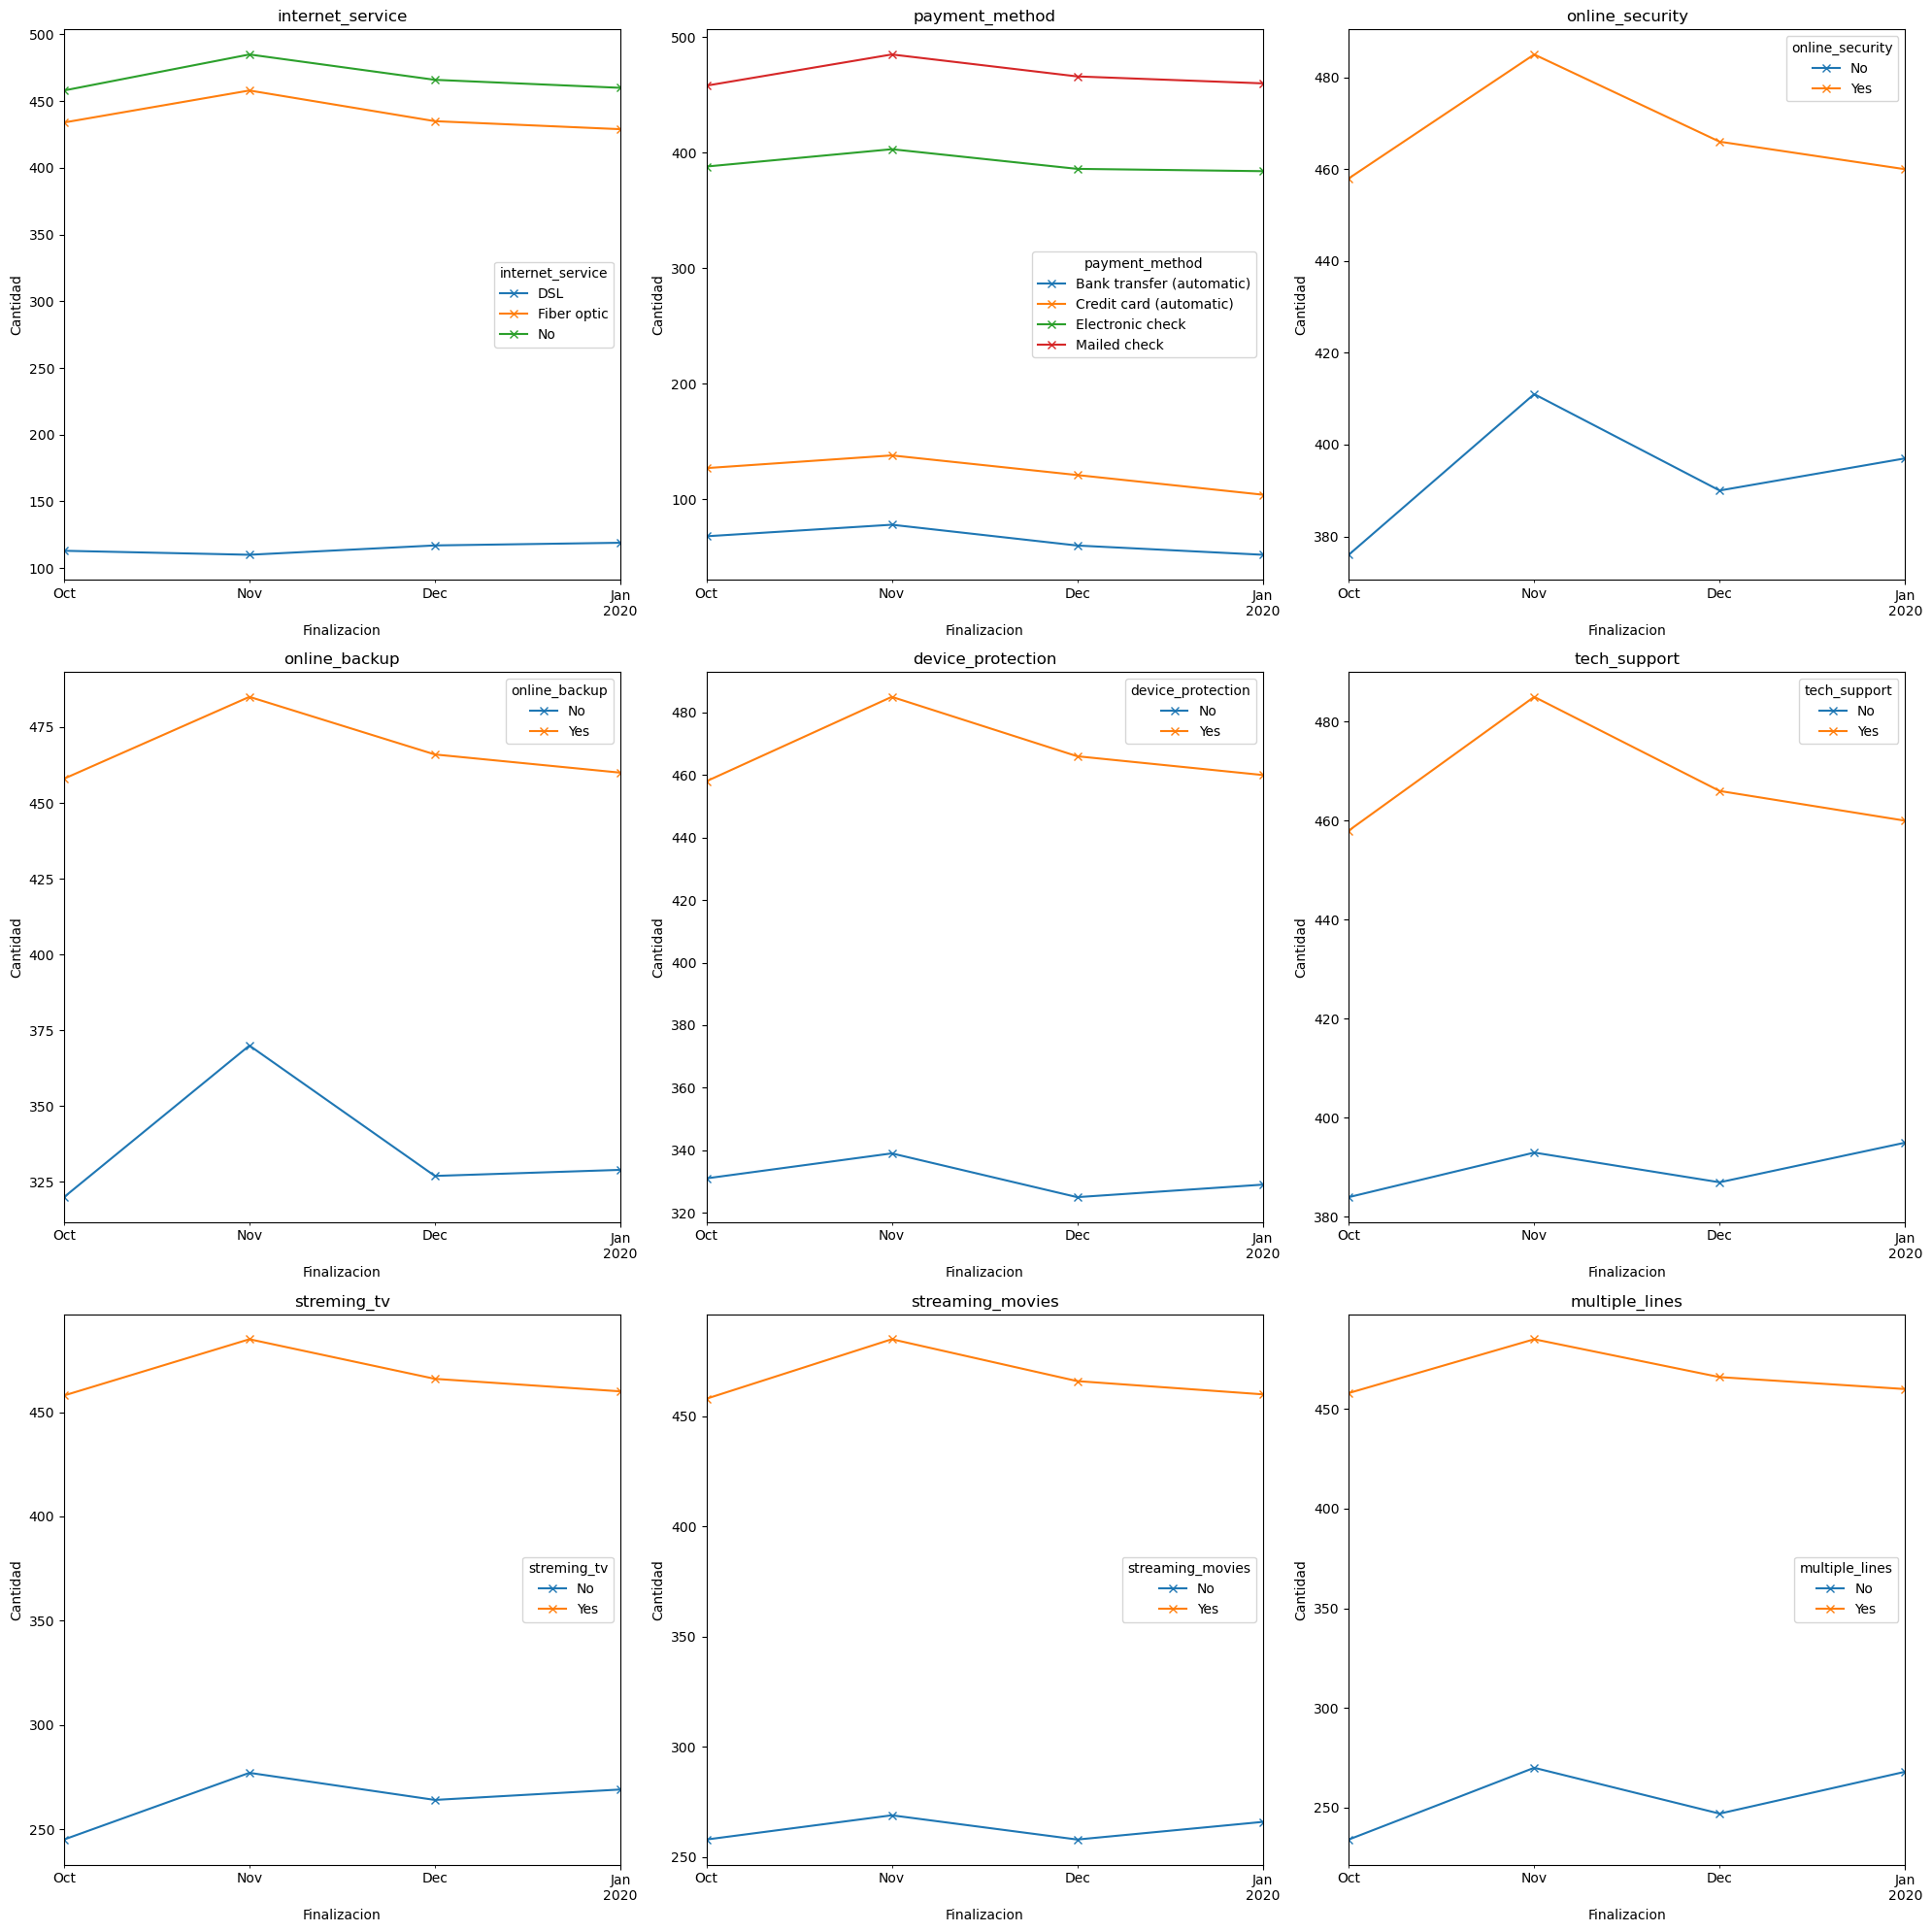

In [36]:
additional_services = ['internet_service', 'payment_method','online_security','online_backup', 'device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for i, service in enumerate(additional_services):
    ax = axes[i // 3, i % 3]
    gender_service = df_merged.groupby(['end_date', service])[service].count().unstack()
    gender_service.plot(kind='line',style='-x', stacked=True, ax=ax)
    ax.set_xlabel('Finalizacion')
    ax.set_ylabel('Cantidad')
    ax.set_title(service)
    ax.legend(title=service)

plt.tight_layout()
plt.show()

desde octubre del 2019 se aprecia la baja de los contratos. DE los mismos la mayoria no tenia contratado servicio de internet.

En la evolucion desde octubre a Enero las bajas se produgeron de forma lineal en todos los servicios adicionales. 

Ahora veremos como ha sido el comportamiento de los clinetes activos para poder visualizar si hubieron cambios en el resto de los usuarios. 


##### Clientes activos

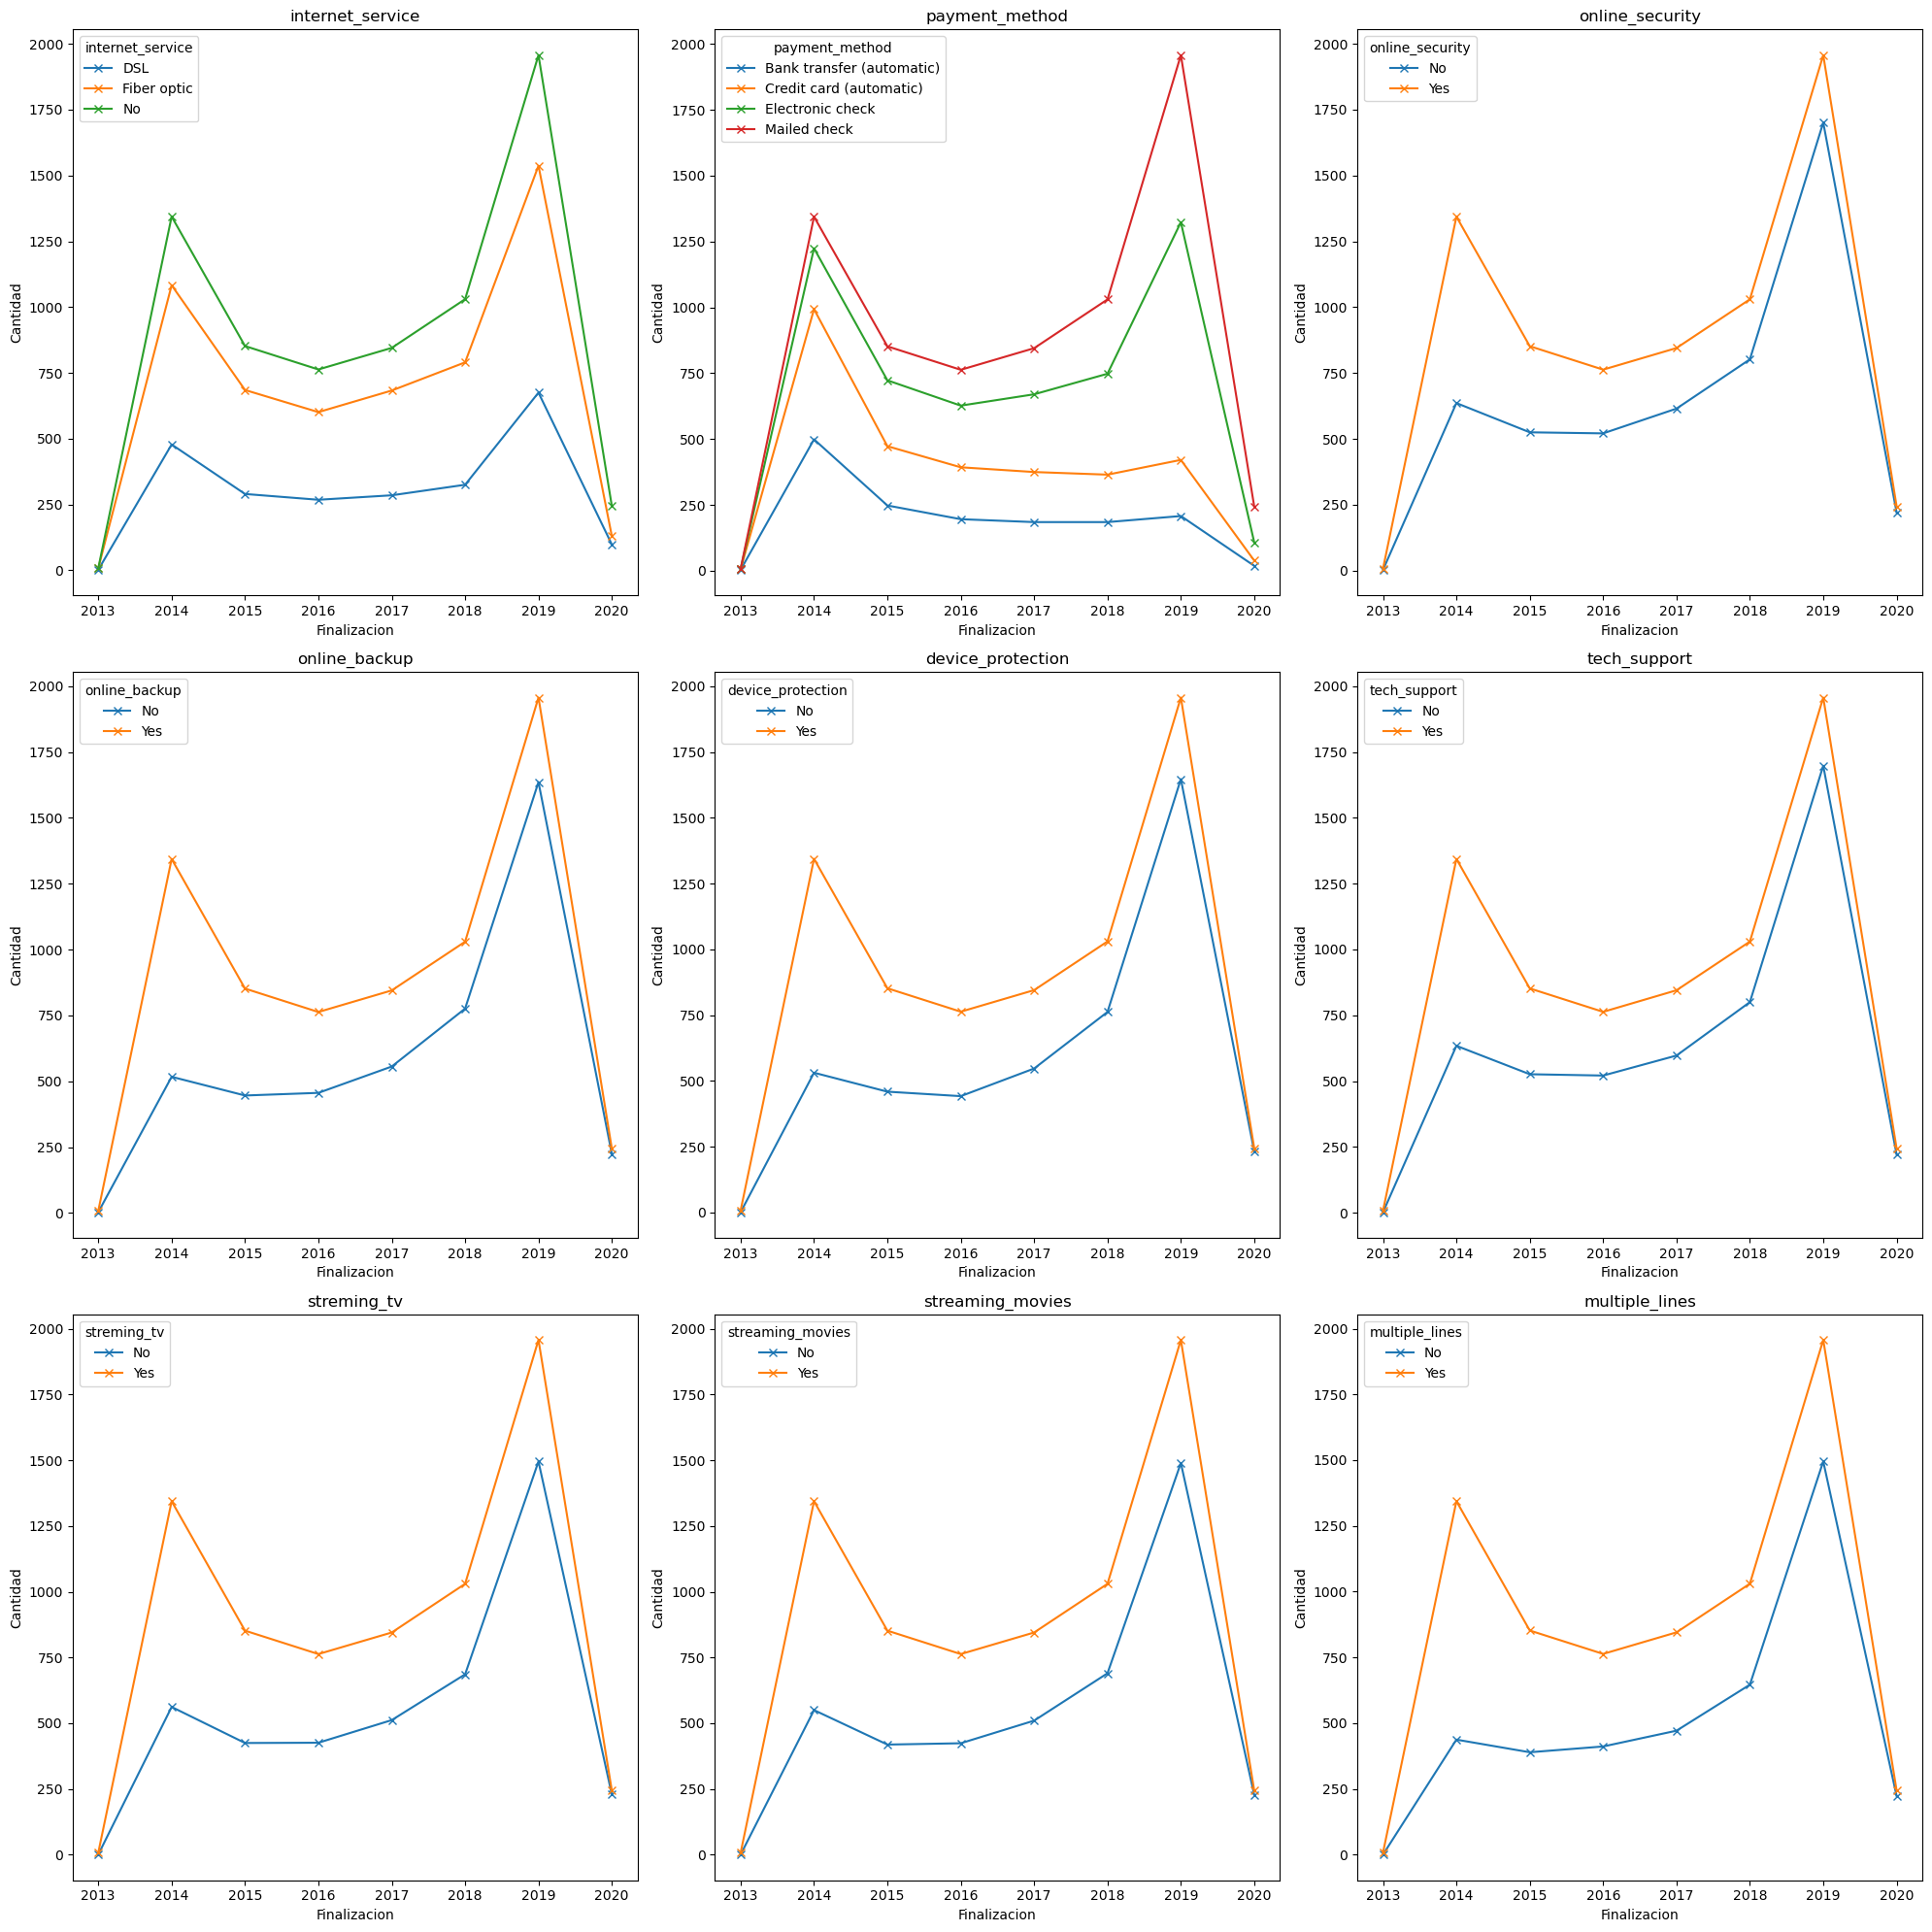

In [37]:
clientes_activos = df_merged.loc[df_merged['end_date'].isnull()]

additional_services = ['internet_service', 'payment_method','online_security','online_backup', 'device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for i, service in enumerate(additional_services):
    ax = axes[i // 3, i % 3]
    gender_service = df_merged.groupby(['year_begin',service])[service].count().unstack()
    gender_service.plot(kind='line', style='-x', stacked=True, ax=ax)
    ax.set_xlabel('Finalizacion')
    ax.set_ylabel('Cantidad')
    ax.set_title(service)
    ax.legend(title=service)

plt.tight_layout()
plt.show()

Se observa un **crecimiento en el 2019** en todos los segmentos respecto a la cantidad de clientes activos.

Veamos puntualmente durante el 2019 que paso con los clientes activos

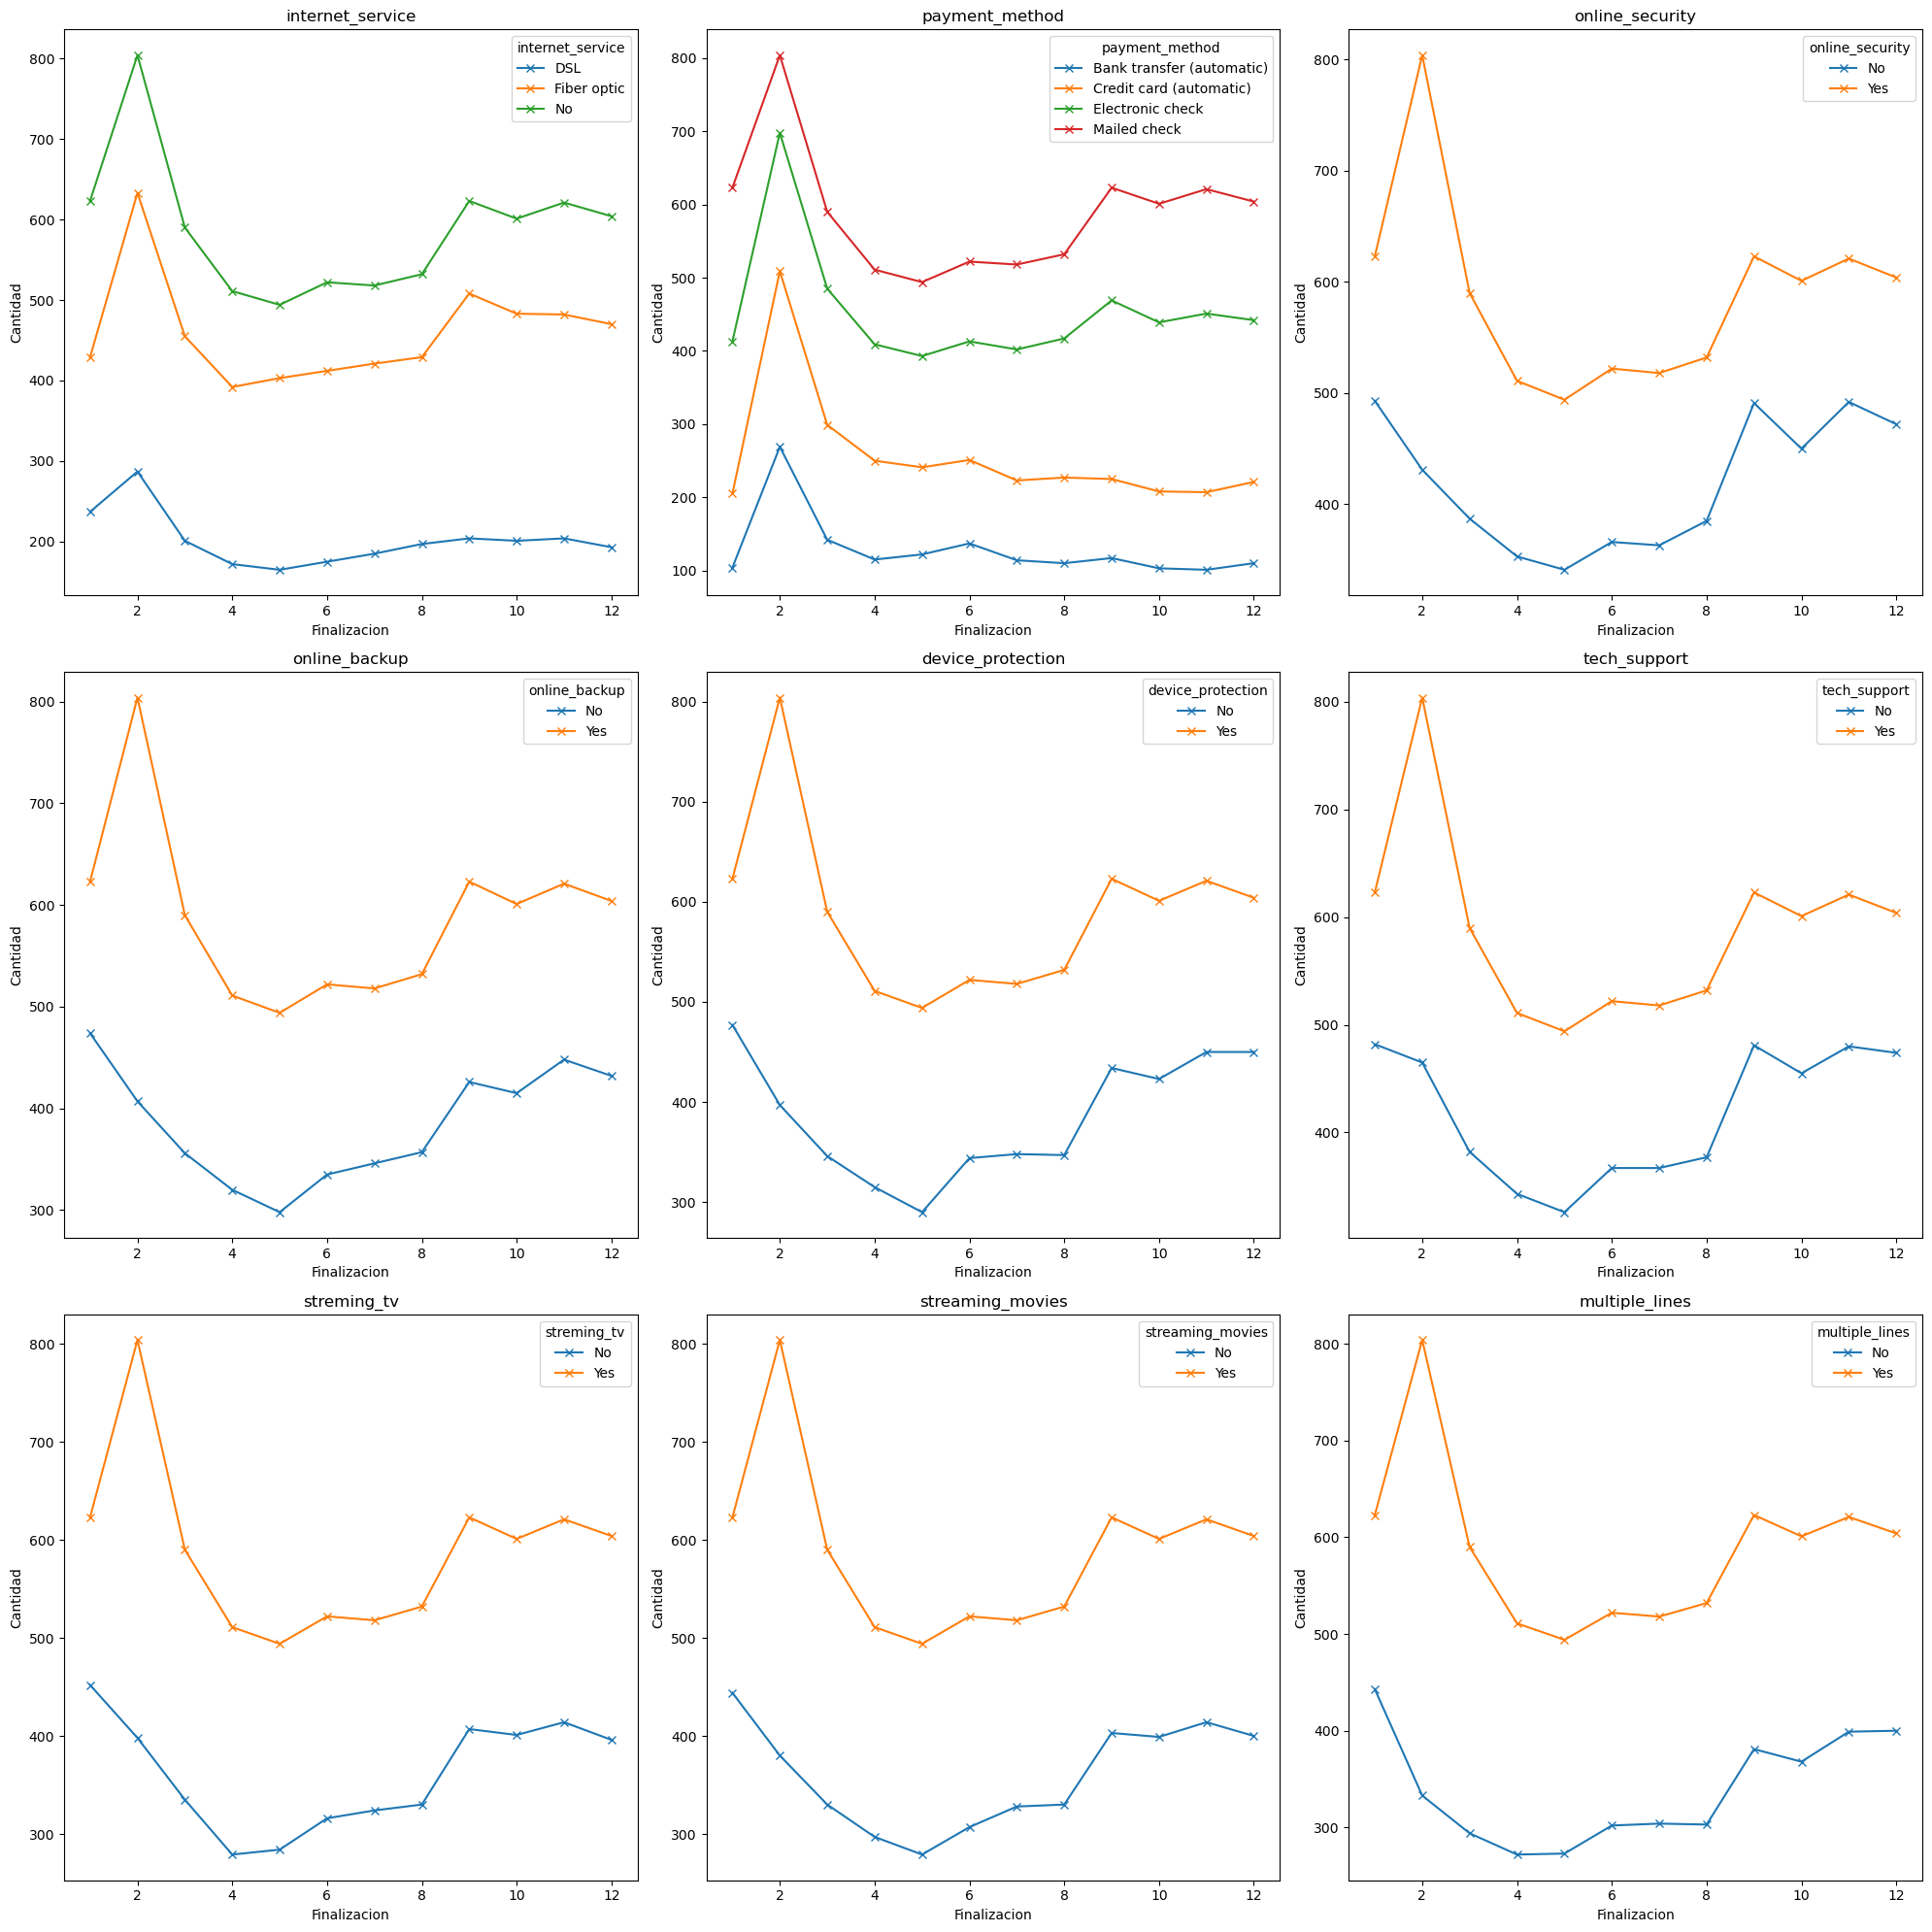

In [38]:
#clientes activos del 2019
clientes_activos = clientes_activos.loc[df_merged['year_begin']==2019]

additional_services = ['internet_service', 'payment_method','online_security','online_backup', 'device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for i, service in enumerate(additional_services):
    ax = axes[i // 3, i % 3]
    gender_service = df_merged.groupby(['month_begin',service])[service].count().unstack()
    gender_service.plot(kind='line', style='-x', stacked=True, ax=ax)
    ax.set_xlabel('Finalizacion')
    ax.set_ylabel('Cantidad')
    ax.set_title(service)
    ax.legend(title=service)

plt.tight_layout()
plt.show()

El crecimiento mas imporante se genero en el mes de Febrero del 2019 en todos los servicios. Luego decrese hasta agosto que vuelve aumentar la tasa de nuevos clientes. 

#### Permanencia

Un dato interesante de observar seria saber cuanto tiempo tuvieron de permanencia los clientes que se dieron de baja, para saber esto vamos a crear un dato adicional.

In [39]:
df_merged['permanencia']=df_merged['end_date']-df_merged['begin_date']
df_merged['permanencia_days'] = df_merged['permanencia'].dt.days

C:\Users\guill\AppData\Local\Temp\ipykernel_12840\3552074708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_baja['permanencia_days'] = clientes_baja['permanencia'].dt.days


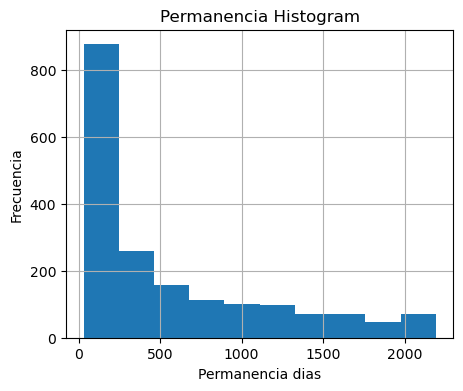

In [40]:
clientes_baja = df_merged.loc[df_merged['permanencia'].notnull()] 
clientes_baja['permanencia_days'] = clientes_baja['permanencia'].dt.days
ancho = 5  # Ancho en pulgadas
alto = 4   # Alto en pulgadas

plt.figure(figsize=(ancho, alto))
clientes_baja['permanencia_days'].hist()

plt.xlabel('Permanencia dias')
plt.ylabel('Frecuencia')
plt.title('Permanencia Histogram')


plt.show()


<Axes: >

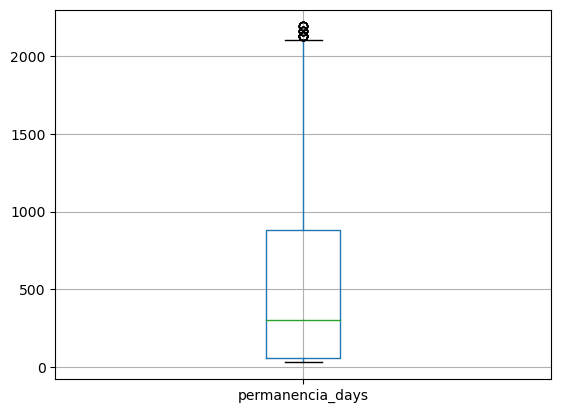

In [41]:
clientes_baja.boxplot(['permanencia_days'])

In [42]:
clientes_baja.loc[clientes_baja['permanencia_days']>60]

customer_id begin_date   end_date            type paperless_billing  \
2     3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   
4     9237-HQITU 2019-09-01 2019-11-01  Month-to-month               Yes   
5     9305-CDSKC 2019-03-01 2019-11-01  Month-to-month               Yes   
8     7892-POOKP 2017-07-01 2019-11-01  Month-to-month               Yes   
13    0280-XJGEX 2015-09-01 2019-10-01  Month-to-month               Yes   
...          ...        ...        ...             ...               ...   
7011  5482-NUPNA 2019-06-01 2019-10-01  Month-to-month               Yes   
7021  1699-HPSBG 2018-11-01 2019-11-01        One year               Yes   
7026  8775-CEBBJ 2019-02-01 2019-11-01  Month-to-month               Yes   
7034  0639-TSIQW 2014-03-01 2019-10-01  Month-to-month               Yes   
7041  8361-LTMKD 2019-07-01 2019-11-01  Month-to-month               Yes   

                 payment_method  monthly_charges  total_charges  year_begin  \
2                  Mailed check            53.85         108.15        2019   
4              Electronic check            70.70         151.65        2019   
5              Electronic check            99.65         820.50        2019   
8              Electronic check           104.80        3046.05        2017   
13    Bank transfer (automatic)           103.70        5036.30        2015   
...                         ...              ...            ...         ...   
7011               Mailed check            60.40         272.15        2019   
7021           Electronic check            59.80         727.80        2018   
7026  Bank transfer (automatic)            44.20         403.35        2019   
7034    Credit card (automatic)           102.95        6886.25        2014   
7041               Mailed check            74.40         306.60        2019   

      month_begin  ...  online_security  online_backup device_protection  \
2              10  ...              Yes            Yes                No   
4               9  ...               No             No                No   
5               3  ...               No             No               Yes   
8               7  ...               No             No               Yes   
13              9  ...               No            Yes               Yes   
...           ...  ...              ...            ...               ...   
7011            6  ...              Yes            Yes                No   
7021           11  ...               No             No                No   
7026            2  ...               No             No                No   
7034            3  ...              Yes            Yes               Yes   
7041            7  ...               No             No                No   

      tech_support streming_tv streaming_movies multiple_lines has_end_date  \
2               No          No               No             No            1   
4               No          No               No             No            1   
5               No         Yes              Yes            Yes            1   
8              Yes         Yes              Yes            Yes            1   
13              No         Yes              Yes            Yes            1   
...            ...         ...              ...            ...          ...   
7011           Yes          No               No             No            1   
7021           Yes         Yes               No             No            1   
7026            No          No               No             No            1   
7034            No         Yes               No            Yes            1   
7041            No          No               No            Yes            1   

     permanencia permanencia_days  
2        61 days               61  
4        61 days               61  
5       245 days              245  
8       853 days              853  
13     1491 days             1491  
...          ...              ...  
7011    122 days             

Por lo visto los clientes que se han dado de baja han tenido una permanencia en la empresa menor a 250 dias y luego disminuye, lo que puede ser un indicio de fidelidad ya que los clientes de mayor antiguedad suelen permanecer en la empresa. 
Tambien puede darse las bajas por el crecimiento en el numero de abonados, lo que podria indicar reduccion en la calidad del servicio o expectativas muy altas de los nuevos usuarios.

#### Tipo de Contrato

In [43]:
tc=clientes_baja.pivot_table(index=['type'], values='customer_id', aggfunc='count')
total_clientes_baja= tc['customer_id'].sum()
tc['porcentaje'] = (tc['customer_id'] / total_clientes_baja) * 100
tc

customer_id  porcentaje
type                                   
Month-to-month         1655   88.550027
One year                166    8.881755
Two year                 48    2.568218

El 88% de los clientes dados de baja han optado por un contrato mensual

In [44]:
clientes_activos = df_merged.loc[df_merged['end_date'].isnull()]
ta=clientes_activos.pivot_table(index=['type'], values='customer_id', aggfunc='count')
total_clientes_activos = ta['customer_id'].sum()
ta['porcentaje'] = (ta['customer_id'] / total_clientes_activos) * 100
ta

customer_id  porcentaje
type                                   
Month-to-month         2220   42.906842
One year               1307   25.260920
Two year               1647   31.832238

Los clientes activos si bien la mayoria opta por un contrato mensual, su porcentaje de participacion es mas baja siendo del 42 %

#### Costos

Vamos ver si el costo del producto tiene relacion con las bajas.

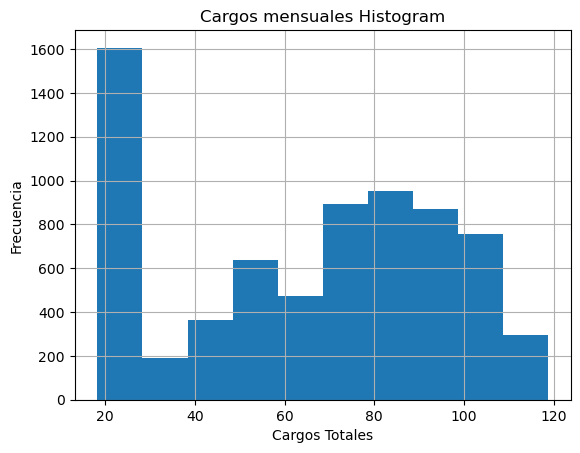

In [45]:
df_merged['monthly_charges'].hist()
plt.xlabel('Cargos Totales')
plt.ylabel('Frecuencia')
plt.title('Cargos mensuales Histogram')

plt.show()

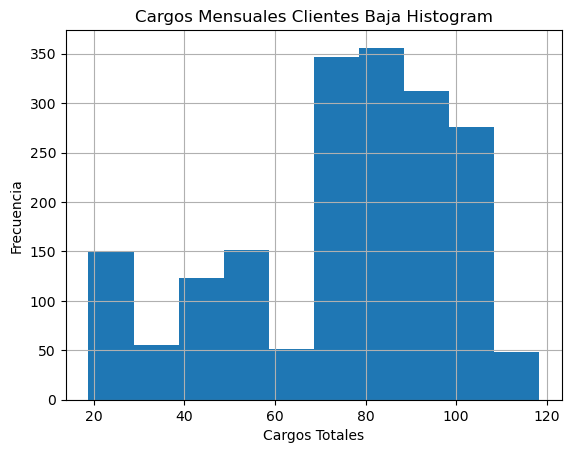

In [46]:
clientes_baja['monthly_charges'].hist()
plt.xlabel('Cargos Totales')
plt.ylabel('Frecuencia')
plt.title('Cargos Mensuales Clientes Baja Histogram')

plt.show()

Como se puede observar la mayoria de los clientes tiene bajos cargos y los clientes que han abandonado no han tenido muchos cargos adicionales, por lo que su salida pareciera no es un tema economico. 

A continuacion seguiremos con el analisis de correlacion para ver relacion de dependencia entre variables y posteriormente seguiremos los pasos necesarios para entrenar y validar los modelos de clasificacion. Nuestro objetivo en la proxima seccion es:

1- lograr identificar algun patron o relacion entre las variables de costos y los dias de permanencia. 

2- relacion Cantidad de servicios con los dias de permanencia.


## Analisis Correlacion y Grafico <a id='3'></a>

#### Relacion entre el abono mensual y los dias de permanencia

<Axes: xlabel='permanencia_days', ylabel='monthly_charges'>

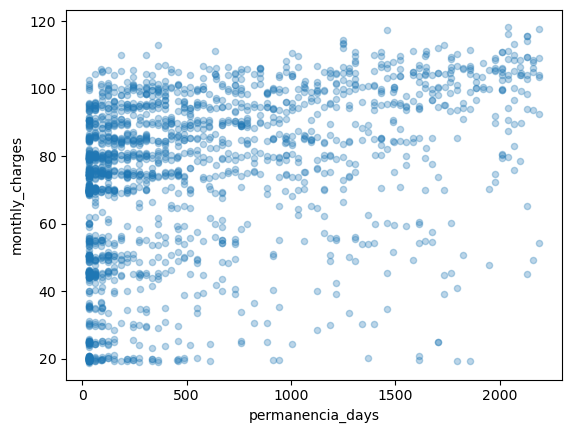

In [47]:
clientes_baja.plot(x='permanencia_days', y='monthly_charges', kind='scatter', alpha=0.3)

Vemos que existe independencia de las variables de permanencia y los cargos mensuales pagados, hay un grupo concentrado de valores entre 0 y 500 dias de permanencia que pagan entre 70 y 90, pero no es concluyente 

#### Relacion Costo total y los dias de permanencia

<Axes: xlabel='permanencia_days', ylabel='total_charges'>

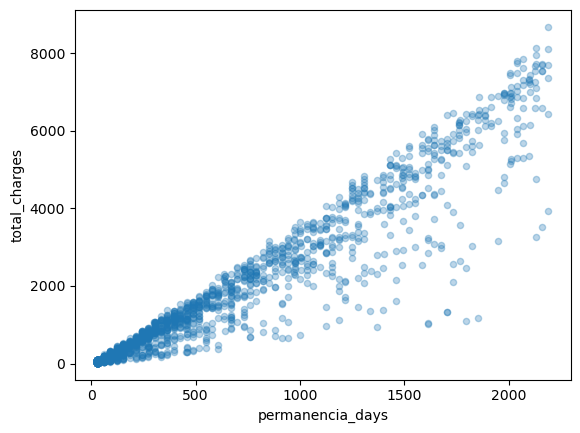

In [48]:
clientes_baja.plot(x='permanencia_days', y='total_charges', kind='scatter', alpha=0.3)

Analizando este grafico existe una correlacion entre los dias de permanencia y el total de cargos, lo que analizando los registros con mayor detalle muestra que la columna `total_charges` es un acumulativo de los cargos mensuales de los usuarios


#### Relacion cantidad de servicios y pertenencia

In [49]:
columnas_a_incluir = ['internet_service', 'online_security', 'online_backup','device_protection', 'tech_support', 'streming_tv', 'streaming_movies', 'multiple_lines']
clientes_baja['cant_serv'] = clientes_baja[columnas_a_incluir].apply(lambda row: (row == 'Yes').sum(), axis=1)

C:\Users\guill\AppData\Local\Temp\ipykernel_12840\1907762251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clientes_baja['cant_serv'] = clientes_baja[columnas_a_incluir].apply(lambda row: (row == 'Yes').sum(), axis=1)


<Axes: title={'center': 'Cantidad de servicios adicionales por usuarios'}, xlabel='cant_serv'>

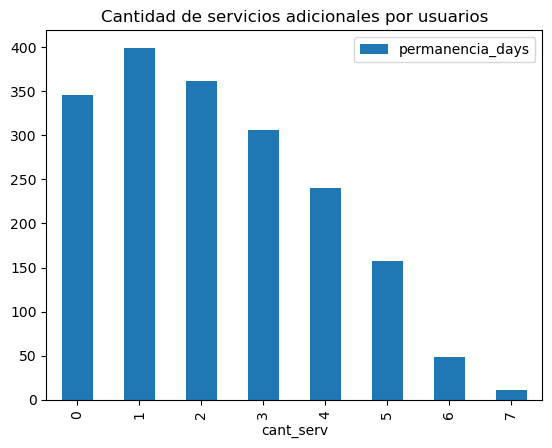

In [50]:
cant_serv=clientes_baja.pivot_table(index=['cant_serv'],values='permanencia_days',aggfunc='count')
cant_serv.plot(kind='bar', title='Cantidad de servicios adicionales por usuarios')

In [51]:

total_general = cant_serv['permanencia_days'].sum()
cant_serv['porcentaje_total'] = (cant_serv['permanencia_days'] / total_general) * 100
cant_serv

permanencia_days  porcentaje_total
cant_serv                                    
0                       346         18.512574
1                       399         21.348315
2                       361         19.315142
3                       306         16.372392
4                       240         12.841091
5                       157          8.400214
6                        49          2.621723
7                        11          0.588550

Existen 346 clientes que se dieron de baja y no tenian contratado ningun servicio que representa un 18.51% por lo que el 81.49% tenia contratado al menos un servicio.

como vemos en la grafica el valor modal se encuentra entre 1 y 2 servicios.

<Axes: xlabel='permanencia_days', ylabel='cant_serv'>

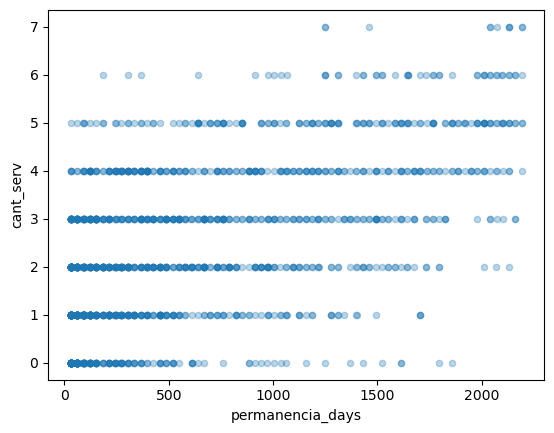

In [52]:
clientes_baja.plot(x='permanencia_days', y='cant_serv', kind='scatter', alpha=0.3)

In [53]:
cant_serv_c=clientes_baja.pivot_table(index=['cant_serv'],values='permanencia_days',aggfunc='count')

<Axes: title={'center': 'Cantidad de dias de permanencia por cantidad de servicios'}, xlabel='cant_serv'>

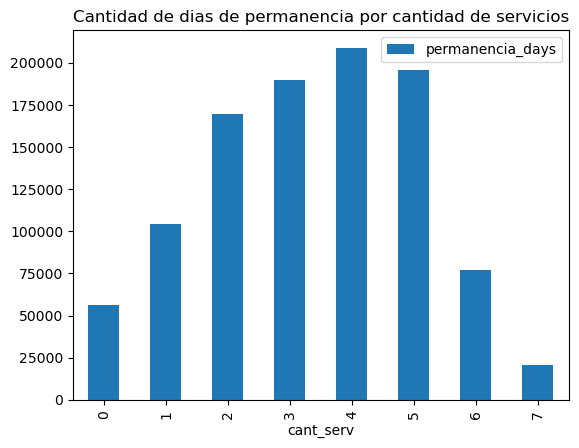

In [54]:
cant_serv=clientes_baja.pivot_table(index=['cant_serv'],values='permanencia_days',aggfunc='sum')
cant_serv.plot(kind='bar', title='Cantidad de dias de permanencia por cantidad de servicios')

quienes han tenido entre 3 y 5 servicios han tenido mayor cantidad de dias de permanencia.

#### conclusiones Intermedias

Del analisis exploratorio y de correlacion podemos responder algunas cuestiones planteadas:

1- No hay un comportamiento determinado segun las caracteristicas de los usuarios, ambos se comportan de igual forma.

2- La baja de los contratos comienza en el mes de octubre de 2019

3- La mayoria de las bajas tenia contratado servicios adicionales, teniendo un igual comportamiento los clientes activos.

4- en 2019 se produce un crecimiento de casi 100% en el ingreso de nuevos usuarios, siendo el pico en el mes de febrero.

5- La mayoria de los clientes activos y dados de baja no tienen contratado el servicio de internet.

6- La mayoria de los clientes activos y dados de baja reciben su factura por correo.

7- La mayoria de los clientes dados de baja no han tenido una permanencia en dia superior a los 100 dias.

8- el 88% de los clientes dados de baja tienen un tipo de contrato mensual, mientras que los clientes activos tienen tan solo un 42% donde mas del 30% opta por contratos de mas de dos años.

9- Los clientes dados de baja pagan mensualmente un monto mayor que los clientes activos.

10- La cantidad de servicios contratados por los clientes dados de baja es entre 1 y 2, donde tan solo un 18.51% no tiene contratado ningun servicio adicional.

11- Los clientes que tienen mas de 4 servicios contratados suelen tener mayor permanencia.


A continuacion seguiremos con la segmentacion de los datos, clasificando las variables segun su pertinencia para su codificacion y posterior segmentacion.

Luego de segmentado los datos comenzaremos la etapa de entrenamiento en diferentes modelos de clasificacion, buscando aquel que mejor nivel de exactitud muestre en sus metricas.


## Segmentacion Datos <a id='3'></a>

vamos a segmentar los datos para el entrenamiento y la validacion, pero previamente vamos a estudiar las caracteristicas de las variables para aplicar tecnicas de codificacion para optimizar los modelos de aprendizaje. 

#### Variables de entrenamiento

utilizaremos para el entrenamiento las siguientes variables y el tratamiento que tendran:
 1   begin_date         
 3   type                  --> **One Hot**         
 4   paperless_billing     --> **codificara**       
 5   payment_method        --> **One Hot**     
 6   monthly_charges          
 7   total_charges                           
 13  gender                --> **One Hot**      
 14  senior_citizen              
 15  partner               --> **One Hot**       
 16  dependents            --> **One Hot**       
 17  internet_service      --> **codificara**       
 18  online_security       --> **codificara**       
 19  online_backup         --> **codificara**      
 20  device_protection     --> **codificara**      
 21  tech_support          --> **codificara**        
 22  streming_tv           --> **codificara**       
 23  streaming_movies      --> **codificara**        
 24  multiple_lines        --> **codificara**      
 26  permanencia_days   
 
 
 La eleccion entre One Hot y Codificacion responde a si la variable es una categoria que no tiene un orden de importancia  o si es un codigo binario de si o no. 

In [55]:
df=df_merged.copy()

In [56]:
#Codificacion One Hot
df=pd.get_dummies(df,columns=['type'],drop_first=False)

In [57]:
#Etiquetado
paperless_billing=df[['paperless_billing']]
internet_service=df[['internet_service']]
online_security=df[['online_security']]
online_backup=df[['online_backup']]
device_protection=df[['device_protection']]
tech_support =df[['tech_support']]
streming_tv=df[['streming_tv']]
streaming_movies=df[['streaming_movies']]
multiple_lines=df[['multiple_lines']]

In [58]:
encoder=OrdinalEncoder()

In [59]:
df['paperless_billing']= pd.DataFrame(encoder.fit_transform(paperless_billing.values))
df['internet_service']= pd.DataFrame(encoder.fit_transform(internet_service.values))
df['online_security']= pd.DataFrame(encoder.fit_transform(online_security.values))
df['online_backup']= pd.DataFrame(encoder.fit_transform(online_backup.values))
df['device_protection']= pd.DataFrame(encoder.fit_transform(device_protection.values))
df['tech_support']= pd.DataFrame(encoder.fit_transform(tech_support.values))
df['streming_tv']= pd.DataFrame(encoder.fit_transform(streming_tv.values))
df['streaming_movies']= pd.DataFrame(encoder.fit_transform(streaming_movies.values))
df['multiple_lines']= pd.DataFrame(encoder.fit_transform(multiple_lines.values))


Ya hemos codificado las variables de la base de datos segun su conveniencia para su entrenamiento y prueba, a continuacion procederemos a segmentar los datos en un 60% para su entrenamiento, un 20% para testear con las metricas y un 20% para las pruebas.

In [60]:
#Dividimos la base de datos

#testeo
df_train, df_valid=train_test_split(df, test_size=0.40, random_state=12345)

#Prueba
df_test, df_prueba=train_test_split(df_valid, test_size=0.50, random_state=12345)

Ya tenemos nuestra base segmentada ahora procederemos a clasificar nuestras variables de entrenamiento y objetivo.

## Entrenamiento Modelo <a id='4'></a>

### Modelizacion

In [61]:
features =df_train.drop(['customer_id','begin_date','end_date','year_end','paperless_billing',
                         'month_end','permanencia','payment_method','type_One year',
                         'gender','partner','dependents','permanencia_days','has_end_date'], axis=1)
target =df_train['has_end_date']

In [62]:
features_test =df_test.drop(['customer_id','begin_date','end_date','year_end','paperless_billing',
                             'month_end','permanencia','payment_method','type_One year',
                             'gender','partner','dependents','permanencia_days','has_end_date'], axis=1)
target_test=df_test['has_end_date']

Hemos excluido de las variables de entrenamiento los campos de id, los campos con calculos de las fechas, algunas variables que no tenian incidencia segun nuestros analisis y la variable objetivo. 

##### Funciones de sobremuestra y submuestra

Incorporaremos funciones para ajustar tanto el sobre muestreo como el sud muestreo para evitar desequilibrio en las clases.

In [63]:
#Funcion de Sobre Muestra
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)

    return features_upsampled, target_upsampled

In [64]:
#Funcion de sub muestra
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

Ahora comenzaremos el entrenamiento en diferentes modelos de clasificacion.

### Arbol de Decision

In [65]:
#tecnicas de muestreos
best_score = 0
best_est = 0
best_precision = 0
best_recall = 0
best_accuracy = 0
best_auc_roc = 0

for est in range(1, 10):
    model = DecisionTreeClassifier(random_state=12345, class_weight=None, max_depth=est)
    model.fit(features, target)
    test_predictions = model.predict(features_test)
    score = f1_score(target_test, test_predictions)
    precision = precision_score(target_test, test_predictions)
    recall = recall_score(target_test, test_predictions)
    accuracy = accuracy_score(target_test, test_predictions)
    auc_roc = roc_auc_score(target_test, test_predictions)

    if auc_roc > best_auc_roc:
        best_score = score
        best_est = est
        best_precision = precision
        best_recall = recall
        best_accuracy = accuracy
        best_auc_roc = auc_roc

arbol_1 = DecisionTreeClassifier(random_state=12345, class_weight=None, max_depth=best_est).fit(features, target)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Precision:', best_precision)
print('Recall:', best_recall)
print('F1 Score:', best_score)
print('Accuracy:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 7
Precision: 0.6909090909090909
Recall: 0.5968586387434555
F1 Score: 0.6404494382022471
Accuracy: 0.8183108587650816
AUC-ROC: 0.748770117813792


C:\Users\guill\anaconda3\Nueva carpeta\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


En este modelo de arbol de decision donde no se espesifico ningun peso las clases, el mejor estimador de nodos es de 6 con un nivel de exactitud del 82.39%  y una superficie debajo de la curva de ROC del 0.74

Ahora probaremos el mismo modelo pero ajustando las clases buscando tecnicas de balanceo, para representar mejor las clases minoritarias. 

In [66]:
#tecnicas de Balanceo
best_score = 0
best_est = 0
best_precision = 0
best_recall = 0
best_accuracy = 0
best_auc_roc = 0

for est in range(1,10):
        model=DecisionTreeClassifier(random_state=12345,class_weight='balanced', max_depth=est)
        model.fit(features,target)
        test_predictions=model.predict(features_test)
        score=f1_score(target_test,test_predictions)
        precision = precision_score(target_test,test_predictions)
        recall = recall_score(target_test,test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)
        
        if auc_roc > best_auc_roc:
            best_score = score
            best_est = est
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy
            best_auc_roc = auc_roc

arbol_2 = DecisionTreeClassifier(random_state=12345, class_weight='balanced', max_depth=best_est).fit(features, target)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Precision:', best_precision)
print('Recall:', best_recall)
print('F1 Score:', best_score)
print('Accuracy:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 8
Precision: 0.5719489981785064
Recall: 0.8219895287958116
F1 Score: 0.6745435016111708
Accuracy: 0.7849538679914834
AUC-ROC: 0.7965838588477597


En este modelo el mejor estimado es 8 nodos con una superficie debajo de la curva de 0.78 y un nivel de exactitud del 75,79% 

A continuacion probaremos el modelo pero aplicando las funciones de sobre ajuste y sud ajuste para evitar que el modelo se ajuste a las clases mayoritarias.

In [67]:
#tecnicas de sobre muestreos
best_score = 0
best_est = 0
best_precision = 0
best_recall = 0
best_accuracy = 0
best_auc_roc = 0

features_upsampled, target_upsampled = upsample(features, target, 10)

for est in range(1,10):
        model=DecisionTreeClassifier(random_state=12345,class_weight='balanced', max_depth=est)
        model.fit(features_upsampled,target_upsampled)
        test_predictions=model.predict(features_test)
        score=f1_score(target_test,test_predictions)
        precision = precision_score(target_test,test_predictions)
        recall = recall_score(target_test,test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)
        
        if auc_roc > best_auc_roc:
            best_score = score
            best_est = est
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy
            best_auc_roc = auc_roc

arbol_3=DecisionTreeClassifier(random_state=12345,class_weight='balanced', max_depth=best_est).fit(features_upsampled,target_upsampled)
                      
print('Mejor estimador')
print('n_estimators:', best_est)
print('Precision:', best_precision)
print('Recall:', best_recall)
print('F1 Score:', best_score)
print('Accuracy:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 8
Precision: 0.5709090909090909
Recall: 0.8219895287958116
F1 Score: 0.6738197424892703
Accuracy: 0.7842441447835344
AUC-ROC: 0.7960970039305251


In [68]:
#tecnicas de sub muestreos
best_score = 0
best_est = 0
best_precision = 0
best_recall = 0
best_accuracy = 0
best_auc_roc = 0

features_downsampled, target_downsampled = downsample(features, target, 0.1)

for est in range(1,10):
        model=DecisionTreeClassifier(random_state=12345,class_weight='balanced', max_depth=est)
        model.fit(features_upsampled,target_upsampled)
        test_predictions=model.predict(features_test)
        score=f1_score(target_test,test_predictions)
        precision = precision_score(target_test,test_predictions)
        recall = recall_score(target_test,test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)
        
        if auc_roc > best_auc_roc:
            best_score = score
            best_est = est
            best_precision = precision
            best_recall = recall
            best_accuracy = accuracy
            best_auc_roc = auc_roc

arbol_4=DecisionTreeClassifier(random_state=12345,class_weight='balanced', max_depth=best_est).fit(features_downsampled,target_downsampled)
                      
print('Mejor estimador')
print('n_estimators:', best_est)
print('Precision:', best_precision)
print('Recall:', best_recall)
print('F1 Score:', best_score)
print('Accuracy:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 8
Precision: 0.5709090909090909
Recall: 0.8219895287958116
F1 Score: 0.6738197424892703
Accuracy: 0.7842441447835344
AUC-ROC: 0.7960970039305251


Aqui el modelo encontro el mejor estimador en 9 nodos con una exactitud del 66,99% y una superficie del 0.74

Dentro de los arboles de decision nuestro mejor estimador lo encontramos en el arbol 2 donde el modelo lo balanceamos y su superficie fue del 0.78

ahora probaremos otros modelos

### Bosque Aleatorio

In [69]:
best_score = 0
best_est = 0
best_depth = 0
best_accuracy = 0
best_auc_roc = 0

for depth in range(1, 100):
    for est in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features, target)
        test_predictions = model.predict(features_test)
        score = f1_score(target_test, test_predictions)
        precision = precision_score(target_test, test_predictions)
        recall = recall_score(target_test, test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)

        if score > best_score:
            best_score = score
            best_depth = depth
            best_est = est
            best_accuracy = accuracy
            best_auc_roc = auc_roc

bosque_1 = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth=best_depth).fit(features, target)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Mejor profundidad')
print('n_depth:', best_depth)
print('Mejor F1')
print('score:', best_score)
print('Precision:', precision)
print('Recall:', recall)
print('Exactitud:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

C:\Users\guill\anaconda3\Nueva carpeta\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guill\anaconda3\Nueva carpeta\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guill\anaconda3\Nueva carpeta\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\guill\anaconda3\Nueva carpeta\lib\site-packages\sklearn\metrics\_cl

Mejor estimador
n_estimators: 9
Mejor profundidad
n_depth: 23
Mejor F1
score: 0.6857962697274032
Precision: 0.7587301587301587
Recall: 0.6256544502617801
Exactitud: 0.8445706174591909
AUC-ROC: 0.7758262514210557


En este modelo de bosques los mejores estimadores serian 17 arboles con 9 nodos de profundidad, obteniendo 0.77 la superficie y una exactitud del 0.84

Ahora ajustaremos el modelo modificando los hiperparametros.

In [70]:
best_score = 0
best_est = 0
best_depth = 0
best_accuracy = 0
best_auc_roc = 0

for depth in range(1, 100):
    for est in range(1, 10):
        model = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=est, max_depth=depth)
        model.fit(features, target)
        test_predictions = model.predict(features_test)
        score = f1_score(target_test, test_predictions)
        precision = precision_score(target_test, test_predictions)
        recall = recall_score(target_test, test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)

        if score > best_score:
            best_score = score
            best_depth = depth
            best_est = est
            best_accuracy = accuracy
            best_auc_roc = auc_roc

bosque_2 = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=best_est, max_depth=best_depth).fit(features, target)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Mejor profundidad')
print('n_depth:', best_depth)
print('Mejor F1')
print('score:', best_score)
print('Precision:', precision)
print('Recall:', recall)
print('Exactitud:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 9
Mejor profundidad
n_depth: 11
Mejor F1
score: 0.6890547263681592
Precision: 0.7287581699346405
Recall: 0.5837696335078534
Exactitud: 0.8225691980127751
AUC-ROC: 0.7919714820271515


Aqui balanceando las clases el modelo mejoro con un AUC- ROC de 0.78 y una exactitud del 84%

In [71]:
best_score = 0
best_est = 0
best_depth = 0
best_accuracy = 0
best_auc_roc = 0

features_upsampled, target_upsampled = upsample(features, target, 10)

for depth in range(1, 100):
    for est in range(1, 10):
        model = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        test_predictions = model.predict(features_test)
        score = f1_score(target_test, test_predictions)
        precision = precision_score(target_test, test_predictions)
        recall = recall_score(target_test, test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)

        if score > best_score:
            best_score = score
            best_depth = depth
            best_est = est
            best_accuracy = accuracy
            best_auc_roc = auc_roc

bosque_3 = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=best_est, max_depth=best_depth).fit(features_upsampled, target_upsampled)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Mejor profundidad')
print('n_depth:', best_depth)
print('Mejor F1')
print('score:', best_score)
print('Precision:', precision)
print('Recall:', recall)
print('Exactitud:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 9
Mejor profundidad
n_depth: 22
Mejor F1
score: 0.70076726342711
Precision: 0.679144385026738
Recall: 0.6649214659685864
Exactitud: 0.8339247693399574
AUC-ROC: 0.7972950238839297


Aplicando la funcion de sobre ajuste mejoramos el modelo opteniendo una superficie de 0.80

In [72]:
best_score = 0
best_est = 0
best_depth = 0
best_accuracy = 0
best_auc_roc = 0

features_downsampled, target_downsampled = downsample(features, target, 0.1)

for depth in range(1, 100):
    for est in range(1, 10):
        model = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        test_predictions = model.predict(features_test)
        score = f1_score(target_test, test_predictions)
        precision = precision_score(target_test, test_predictions)
        recall = recall_score(target_test, test_predictions)
        accuracy = accuracy_score(target_test, test_predictions)
        auc_roc = roc_auc_score(target_test, test_predictions)

        if score > best_score:
            best_score = score
            best_depth = depth
            best_est = est
            best_accuracy = accuracy
            best_auc_roc = auc_roc

bosque_4 = RandomForestClassifier(random_state=12345,class_weight='balanced', n_estimators=best_est, max_depth=best_depth).fit(features_downsampled, target_downsampled)

print('Mejor estimador')
print('n_estimators:', best_est)
print('Mejor profundidad')
print('n_depth:', best_depth)
print('Mejor F1')
print('score:', best_score)
print('Precision:', precision)
print('Recall:', recall)
print('Exactitud:', best_accuracy)
print('AUC-ROC:', best_auc_roc)

Mejor estimador
n_estimators: 3
Mejor profundidad
n_depth: 3
Mejor F1
score: 0.6289424860853432
Precision: 0.40451977401129946
Recall: 0.93717277486911
Exactitud: 0.71611071682044
AUC-ROC: 0.7699100720341359


Dentro de los modelos de bosques el que mejor metricas obtiene es el balanceado con sobre ajuste.

Ahora utilizaremos otros modelos basados en regresiones. 

### Regresion Logistica

In [73]:

model = LogisticRegression(random_state=12345, solver='liblinear')


RL = model.fit(features, target)
test_predictions = model.predict(features_test)
test_probabilities = model.predict_proba(features_test)[:, 1]

precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
exactitud = accuracy_score(target_test, test_predictions)
f1 = (2 * precision * recall) / (precision + recall)
auc_roc = roc_auc_score(target_test, test_probabilities)


print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Exactitud:', exactitud)
print('AUC-ROC:', auc_roc)

Precision: 0.6644295302013423
Recall: 0.518324607329843
F1: 0.5823529411764706
Exactitud: 0.7984386089425124
AUC-ROC: 0.8472932395988927


En el modelo de regresion logistica sin balancear mejoramos nuestras metricas con una superficie de 0.84 y una exactitud de 0.80

Ahora ajustaremos el modelo para mejorar las metricas.

In [74]:
#regresion logistica balanceado
model = LogisticRegression(random_state=12345,class_weight='balanced', solver='liblinear')


RL_2 = model.fit(features, target)
test_predictions = model.predict(features_test)
test_probabilities = model.predict_proba(features_test)[:, 1]

precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
exactitud = accuracy_score(target_test, test_predictions)
f1 = (2 * precision * recall) / (precision + recall)
auc_roc = roc_auc_score(target_test, test_probabilities)


print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Exactitud:', exactitud)
print('AUC-ROC:', auc_roc)

Precision: 0.5133333333333333
Recall: 0.806282722513089
F1: 0.6272912423625254
Exactitud: 0.7402413058907026
AUC-ROC: 0.8468548152755191


In [75]:
#regresion logistica balanceado con sobremuestra
model = LogisticRegression(random_state=12345,class_weight='balanced', solver='liblinear')

features_upsampled, target_upsampled = upsample(features, target, 10)

RL_3 = model.fit(features_upsampled, target_upsampled)
test_predictions = model.predict(features_test)
test_probabilities = model.predict_proba(features_test)[:, 1]

precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
exactitud = accuracy_score(target_test, test_predictions)
f1 = (2 * precision * recall) / (precision + recall)
auc_roc = roc_auc_score(target_test, test_probabilities)


print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Exactitud:', exactitud)
print('AUC-ROC:', auc_roc)

Precision: 0.5167224080267558
Recall: 0.8089005235602095
F1: 0.6306122448979592
Exactitud: 0.7430801987224982
AUC-ROC: 0.8470536356082118


In [76]:
#regresion logistica balanceado con sobremuestra
model = LogisticRegression(random_state=12345,class_weight='balanced', solver='liblinear')

features_downsampled, target_downsampled = downsample(features, target, 0.1)

RL_4 = model.fit(features_downsampled, target_downsampled)
test_predictions = model.predict(features_test)
test_probabilities = model.predict_proba(features_test)[:, 1]

precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
exactitud = accuracy_score(target_test, test_predictions)
f1 = (2 * precision * recall) / (precision + recall)
auc_roc = roc_auc_score(target_test, test_probabilities)


print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Exactitud:', exactitud)
print('AUC-ROC:', auc_roc)

Precision: 0.5197934595524957
Recall: 0.7905759162303665
F1: 0.6272066458982346
Exactitud: 0.7452093683463449
AUC-ROC: 0.8428070372201859


De los modelos de regresion logistica aplicados el que mejora sus metricas es el balanceado con sobre ajustado con un AUC-RO de 0,84

Ahora probaremos otro modelo basado en desenso del gradiente con el objetivo de mejorar nuestra metrica.

### Light BGM

In [77]:
# Crear el conjunto de datos de entrenamiento de LightGBM
train_data = lgb.Dataset(data=features, label=target)

# Especificar los parámetros del modelo (puedes ajustar estos parámetros según tus necesidades)
params = {
    'objective': 'binary',  # Para clasificación binaria
    'metric': 'binary_logloss',  # Función de pérdida para clasificación binaria
    'boosting_type': 'gbdt',  # Tipo de boosting (gradient boosting)
    'num_leaves': 25,  # Número máximo de hojas en un árbol
    'learning_rate': 0.05,  # Tasa de aprendizaje
    'feature_fraction': 0.9,  # Proporción de características utilizadas en cada árbol
    'max_depth': 9,  # Limitar la profundidad máxima del árbol
    'min_child_samples': 10,  # Establecer el número mínimo de muestras en un nodo hoja
    'subsample': 0.9,  # Reducir el muestreo de datos en cada árbol
    'colsample_bytree': 0.9,  # Reducir el muestreo de características en cada árbol
}

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=100)
lightgbm=model

# Realizar predicciones en el conjunto de prueba
y_pred_prob = model.predict(features_test)
y_pred = np.where(y_pred_prob >= 0.25, np.ceil(y_pred_prob), np.floor(y_pred_prob))

# Evaluar el modelo
accuracy = accuracy_score(target_test, y_pred)
roc_auc = roc_auc_score(target_test, y_pred_prob)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 1101, number of negative: 3124
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260592 -> initscore=-1.042895
[LightGBM] [Info] Start training from score -1.042895
Accuracy: 0.8084
ROC AUC: 0.9156


Aplicando el modelo de Light GMB con desenso de gradiente para un problema de clasificacion binaria, hemos podido encontrar un AUC-ROC superior a 0.9 considerando esta metrica como aceptable.

### Cat Bot

In [78]:
# Crea un objeto Pool para los datos de entrenamiento y validación
class_weights = [1, 1]
model = CatBoostClassifier(iterations=1000, # Número de iteraciones (épocas)
                           learning_rate=0.05, # Tasa de aprendizaje
                           depth=10,
                           class_weights=class_weights) # Profundidad del árbol

catbot_1=model.fit(features, target, eval_set=(features_test, target_test), early_stopping_rounds=50, verbose=50)
catbot_1

0:	learn: 0.6546478	test: 0.6564704	best: 0.6564704 (0)	total: 153ms	remaining: 2m 32s
50:	learn: 0.3022537	test: 0.3464946	best: 0.3464946 (50)	total: 790ms	remaining: 14.7s
100:	learn: 0.2437570	test: 0.3261638	best: 0.3260642 (98)	total: 1.64s	remaining: 14.6s
150:	learn: 0.1996288	test: 0.3162968	best: 0.3162968 (150)	total: 2.54s	remaining: 14.3s
200:	learn: 0.1672878	test: 0.3065365	best: 0.3065365 (200)	total: 3.46s	remaining: 13.8s
250:	learn: 0.1418154	test: 0.3014095	best: 0.3007277 (245)	total: 4.33s	remaining: 12.9s
300:	learn: 0.1217507	test: 0.2974644	best: 0.2969781 (283)	total: 5.2s	remaining: 12.1s
350:	learn: 0.1050242	test: 0.2962764	best: 0.2956093 (337)	total: 6.05s	remaining: 11.2s
400:	learn: 0.0915706	test: 0.2950337	best: 0.2944383 (387)	total: 6.96s	remaining: 10.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.294438278
bestIteration = 387

Shrink model to first 388 iterations.


In [79]:
y_pred = model.predict(features_test)

In [80]:
accuracy = accuracy_score(target_test, y_pred)
y_pred_proba = model.predict_proba(features_test)[:, 1]  # Obtenemos las probabilidades de la clase positiva
umbral = 0.25
y_pred_binario = (y_pred_proba >= umbral).astype(int)
auc_roc = roc_auc_score(target_test, y_pred_binario)

print("Accuracy:", accuracy)
print("AUC ROC:", auc_roc)

Accuracy: 0.8836053938963804
AUC ROC: 0.8306879183511168


### XGB Classifier

In [81]:

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=1234)
xgb=clf.fit(features, target)
y_pred = clf.predict(features_test)
y_prob = clf.predict_proba(features_test)[:, 1]

auc_score = roc_auc_score(target_test, y_prob)
accuracy = accuracy_score(target_test, y_pred)

print("AUC:", auc_score)
print("Exactitud:", accuracy)

AUC: 0.9190954184658208
Exactitud: 0.8786373314407381


#### Resumen de metricas

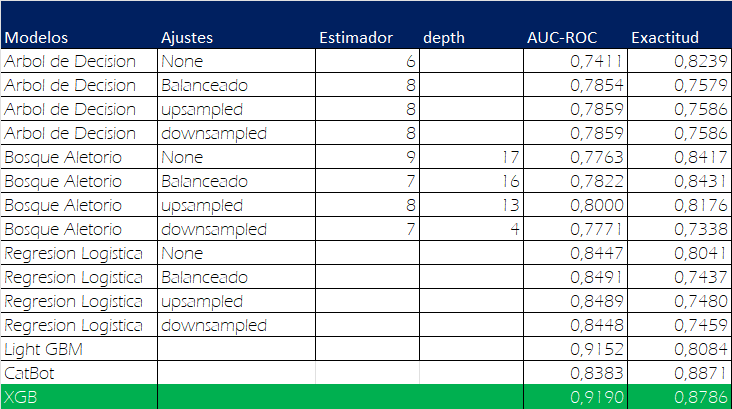

El mejor modelo es el XGB con una curva de AUC-ROC de 0.9190 y una exactitud del 87% 

A continuacion analizaremos la grafica de la curva de  AUC-ROC para los mejores estimadores de cada modelo.

### Grafica AUC <a id='5'></a>

In [82]:
#Calculamos los falsos positivos (fpr) y los verdaderos positivos (tpr). La superficie de la curva la llamamos (auc)
def get_roc_plot_data(y, predictions):
    fpr, tpr, _ = roc_curve(y,
                            predictions,
                            pos_label=None,
                            drop_intermediate=True)
    auc = round(roc_auc_score(y, predictions), 5)
    
    return fpr, tpr, auc
    

def plot_roc(custom_axis, y, predictions):
    
    multiple_curves = isinstance(y, dict)
    
    custom_axis.axis([-0.01,1.01,0,1.01])
    custom_axis.set(xlabel="False Positive Rate", ylabel="Recall")
    custom_axis.set_title("ROC Curve")
    
    if not multiple_curves:
        fpr, tpr, auc = get_roc_plot_data(y, predictions)
        
        custom_axis.plot(fpr, tpr)
        custom_axis.text(0.65, 0.02, 'AUC: ' + str(auc), fontsize=12)
    else:
        for i in range(len(y)):
            model = list(y.keys())[i]
            fpr, tpr, auc = get_roc_plot_data(y[model], predictions[model])
            
            custom_axis.plot(fpr, tpr, label=model)
            custom_axis.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            custom_axis.text(0.50, 0.02 + i*0.1, f"{model} AUC: {str(auc)}", fontsize=12)
    
    custom_axis.plot([0,1],[0,1])
    
    return []

In [83]:
#Calcular los estimadores del test
y_arbol = arbol_3.predict_proba(features_test)[:, 1]
y_bosque = bosque_3.predict_proba(features_test)[:, 1]
y_RL = RL_2.predict_proba(features_test)[:, 1]
y_lightgbm = lightgbm.predict(features_test)
y_catbot=catbot_1.predict_proba(features_test)[:, 1]
y_xgb=xgb.predict_proba(features_test)[:, 1]

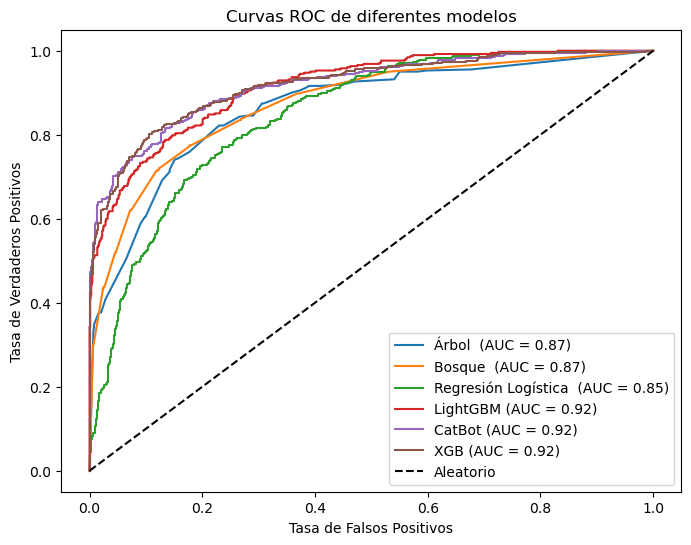

In [84]:
# Calcular las tasas de falsos positivos (fpr) y verdaderos positivos (tpr) para cada modelo
fpr_arbol, tpr_arbol, _ = roc_curve(target_test, y_arbol)
fpr_bosque, tpr_bosque, _ = roc_curve(target_test, y_bosque)
fpr_RL, tpr_RL, _ = roc_curve(target_test, y_RL)
fpr_lightgbm, tpr_lightgbm, _ = roc_curve(target_test, y_lightgbm)
fpr_catbot, tpr_catbot, _ = roc_curve(target_test, y_catbot)
fpr_xgb, tpr_xgb, _ = roc_curve(target_test, y_xgb)

# Calcular el área bajo la curva ROC (AUC) para cada modelo
auc_arbol = roc_auc_score(target_test, y_arbol)
auc_bosque = roc_auc_score(target_test, y_bosque)
auc_RL = roc_auc_score(target_test, y_RL)
auc_lightgbm = roc_auc_score(target_test, y_lightgbm)
auc_catbot = roc_auc_score(target_test, y_catbot)
auc_xgb = roc_auc_score(target_test, y_xgb)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar las curvas ROC para cada modelo
ax.plot(fpr_arbol, tpr_arbol, label=f'Árbol  (AUC = {auc_arbol:.2f})')
ax.plot(fpr_bosque, tpr_bosque, label=f'Bosque  (AUC = {auc_bosque:.2f})')
ax.plot(fpr_RL, tpr_RL, label=f'Regresión Logística  (AUC = {auc_RL:.2f})')
ax.plot(fpr_lightgbm, tpr_lightgbm, label=f'LightGBM (AUC = {auc_lightgbm:.2f})')
ax.plot(fpr_catbot, tpr_catbot, label=f'CatBot (AUC = {auc_catbot:.2f})')
ax.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')

# Agregar detalles al gráfico
ax.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
ax.set_xlabel('Tasa de Falsos Positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos')
ax.set_title('Curvas ROC de diferentes modelos')
ax.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

Aqui podemos visualizar como el modelo de Light GBM que tienen la mayor superficie tiene un comportamiento simetrico entre la tasa de los falsos positivos y la tasa de los verdadero positivo, a diferencia del resto de los modelos que ademas de tener una superficie menor, tienen comportamiento diferentes entre los daltos positivos y los verdaderos positivos. 

El mejor modelo es el XGB y es el que utilizaremos para nuestra prueba. 

## Prueba

In [85]:
features_prueba =df_prueba.drop(['customer_id','begin_date','end_date','year_end','paperless_billing',
                         'month_end','permanencia','payment_method','type_One year',
                         'gender','partner','dependents','permanencia_days','has_end_date'], axis=1)
target_prueba=df_prueba['has_end_date']

In [86]:
#Calcular los estimadores del test

y_xgb=xgb.predict_proba(features_prueba)[:, 1]

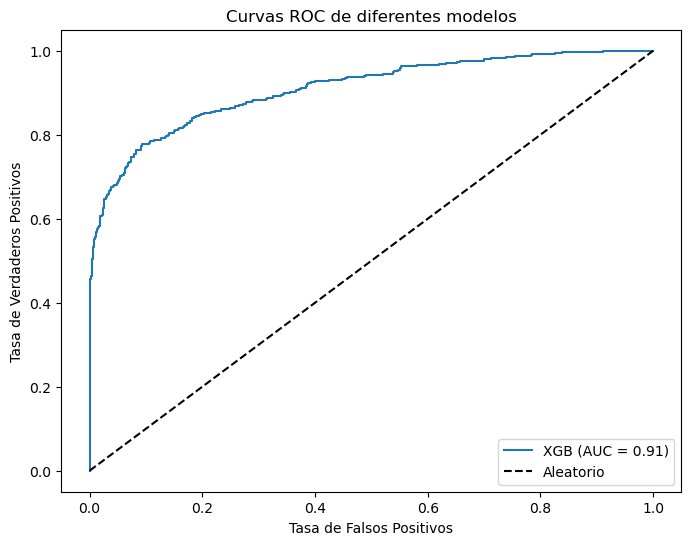

In [88]:
# Calcular las tasas de falsos positivos (fpr) y verdaderos positivos (tpr) para cada modelo


fpr_xgb, tpr_xgb, _ = roc_curve(target_prueba, y_xgb)

# Calcular el área bajo la curva ROC (AUC) para cada modelo

auc_xgb = roc_auc_score(target_prueba, y_xgb)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar las curvas ROC para cada modelo

ax.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_xgb:.2f})')

# Agregar detalles al gráfico
ax.plot([0, 1], [0, 1], 'k--', label='Aleatorio')
ax.set_xlabel('Tasa de Falsos Positivos')
ax.set_ylabel('Tasa de Verdaderos Positivos')
ax.set_title('Curvas ROC de diferentes modelos')
ax.legend(loc='lower right')

# Mostrar el gráfico
plt.show()

En la base de datos de Prueba tambien coincide que nuestro modelo con mejor superficie es el XGB con un valor de 0.91

## Conclusiones <a id='6'></a>

Hemos exportado las librerias necesarias y extraido los datos de 4 data frame, todos conectados por medio del campo customerID. Estudiamos la cantidad de registros y los tipos de datos, convirtiendo los necesarios para estudiar la existencia de valores ausentes.

Se encontraron valores ausentes vinculados a las fechas de finalizacion de contrato, y el total de cargos, se aplicaron diferentes metodos para completar los valores ausentes.

Se unieron las 4 bases en una por medio del metodo merged

Se partio con diferentes preguntas de relevamiento y se optuvieron las siguientes conclusiones:

 - 1) No hay un comportamiento determinado segun las caracteristicas de los usuarios, ambos se comportan de igual forma.

 - 2) La baja de los contratos comienza en el mes de octubre de 2019

 - 3- La mayoria de las bajas tenia contratado servicios adicionales, teniendo un igual comportamiento los clientes activos.

 - 4- en 2019 se produce un crecimiento de casi 100% en el ingreso de nuevos usuarios, siendo el pico en el mes de febrero.

 - 5- La mayoria de los clientes activos y dados de baja no tienen contratado el servicio de internet.

 - 6- La mayoria de los clientes activos y dados de baja reciben su factura por correo.

 - 7- La mayoria de los clientes dados de baja no han tenido una permanencia en dia superior a los 100 dias.

-  8- el 88% de los clientes dados de baja tienen un tipo de contrato mensual, mientras que los clientes activos tienen tan solo un 42% donde mas del 30% opta por contratos de mas de dos años.

-  9- Los clientes dados de baja pagan mensualmente un monto mayor que los clientes activos.

 - 10- La cantidad de servicios contratados por los clientes dados de baja es entre 1 y 2, donde tan solo un 18.51% no tiene contratado ningun servicio adicional.

- 11- Los clientes que tienen mas de 4 servicios contratados suelen tener mayor permanencia.


posteriormente se aplicaron tecnicas de codificacion One Hot y de etiquetas para poder trabajar los datos en los modelos de entrenamiento de la siguiente forma:
- type --> One Hot
+ paperless_billing --> codificara
+ payment_method --> One Hot
+ monthly_charges
+ total_charges
+ gender --> One Hot
+ senior_citizen
+ partner --> One Hot
+ dependents --> One Hot
+ internet_service --> codificara
+ online_security --> codificara
+ online_backup --> codificara
+ device_protection --> codificara
+ tech_support --> codificara
+ streming_tv --> codificara
+ streaming_movies --> codificara
+ multiple_lines --> codificara
+ permanencia_days

Se seleccionaron las variables para el entrenamiento excluyendo las vinculadas al id, a la fechas de finalizacion, variables no relevantes y la variable objetivo. 

Luego se entrenaron difentes modelos de clasificacion:
* Arbol de Decision
* Bosque Aleatorio
* regresion Logistica
* Light GBM
* Cat Bot
* XGB

a su vez dentro de estos modelos se aplicaron modificaciones de los hiperparametros y se aplicaron funciones para evitar sobre ajuste o sub ajuste de las clases.

Se evaluaron las metricas de AUC- ROC y exactitud las cuales dieron los siguientes Resultados:



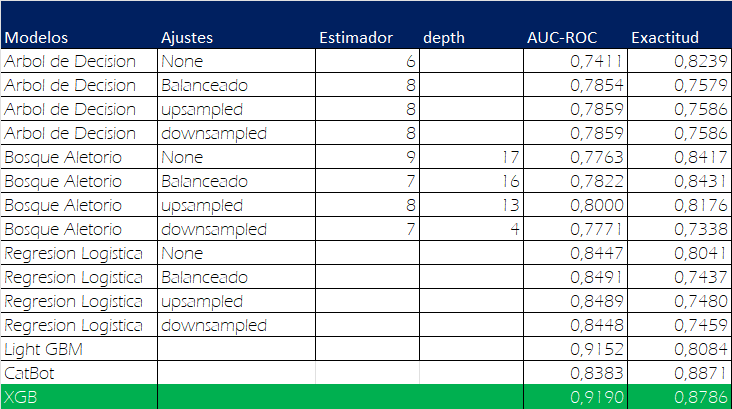

El mejor modelo es el XGB con una superficie de 0.9190 y 87.86% de exactitud

Esto se pudo corroborar tambien por medio de la base de prueba, por lo que este sera el modelo utilizado para cumplir con el objetivo de este proyecto.